In [37]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pmdarima as pm
from functools import reduce
import seaborn as sns

%run Thesis_Model_Function.ipynb

Run Complete: 15/07/2024 14:55:12


In [38]:
%run Thesis_Norway_Data_Prep.ipynb

Run Complete: 15/07/2024 14:55:13
Run Complete: 15/07/2024 14:55:16


## VARMAX Model Selection 

In [36]:
# Model Selection Needed
#  - No Exogenous variables pre COVID period - Best model 1 common, 2 regional, 2 AR , 3 MA 
#  - With Exogenous variables pre-COVID period - Best Model 1 common, 3 regional , 2 AR,2MA

#Not Necessary
#  - No Exogenous variables COVID period - Best Model 2 common, 3 regional, 2 AR, 4 MA
#  - With Exogenous variables COVID period - Best Model 3 common, 3 regional, 2 AR, 2 MA
import numpy as np
import random

train_size = 60
regional_logmort_train = inlandet_logmort_full.iloc[:, :train_size]
country_logmort_train = all_nor_logmort.iloc[:, :train_size]
num_iters = 100
common_limit = 5
regional_limit = 5
ar_limit = 6
ma_limit = 6

track_params = np.full((common_limit+1, regional_limit+1, ar_limit+1, ma_limit+1), 0)
error_store = np.full((common_limit+1, regional_limit+1, ar_limit+1, ma_limit+1), np.inf)

for i in range(num_iters):
    # Initialize random parameters
    common_terms = random.randint(1, common_limit)
    regional_terms = random.randint(1, regional_limit)
    ar = random.randint(1, ar_limit)
    ma = random.randint(1, ma_limit)
    
    # Generate new parameters if already used
    while track_params[common_terms, regional_terms, ar, ma] == 1:
        common_terms = random.randint(1, common_limit)
        regional_terms = random.randint(1, regional_limit)
        ar = random.randint(1, ar_limit)
        ma = random.randint(1, ma_limit)
    
    try:
        # Train the model
        track_params[common_terms, regional_terms, ar, ma] = 1
        _, _, _, _, _, _, _, _, _, _, model, _, test_errors,_,_ = VARMAX_model(
            country_logmort_train, regional_logmort_train, 
            common_terms=common_terms, regional_terms=regional_terms, 
            prediction_period=20, train_period=40, AR=ar+1, MA=ma+1,
            
#             exogenous_train=exog_train_inlandet, exogenous_test=exog_test_inlandet,
#             country_deaths=nor_death, country_pop=nor_pop, 
#             region_deaths=inlandet_death, region_pop=inlandet_pop,
            
            exogenous_train=exog_train_inlandet_select, exogenous_test=exog_test_inlandet_select,
            country_deaths=nor_death_select, country_pop=nor_pop_select, 
            region_deaths=inlandet_death_select, region_pop=inlandet_pop_select,
            re_est=False)
        print(test_errors)
        # Store the mean of test_errors in the appropriate location
        error_store[common_terms, regional_terms, ar, ma] = np.mean(test_errors) 
    except Exception as e:
        print(f"Error in configuration: AR={ar+1}, MA={ma+1}, Common Terms={common_terms}, Regional Terms={regional_terms}. Error: {str(e)}")
        error_store[common_terms, regional_terms, ar, ma] = np.inf  # Set a large error value
                
    print(f"Configuration {i+1} processed: AR={ar+1}, MA={ma+1}, Common Terms={common_terms}, Regional Terms={regional_terms}, Error={error_store[common_terms, regional_terms, ar, ma]}")

    
    
    
print(np.where(error_store == np.min(error_store)))

[33.32332381 67.64307626 10.73359327  5.34545879 13.06791583  8.94873378
 13.32063359]
Configuration 1 processed: AR=6, MA=3, Common Terms=3, Regional Terms=2, Error=21.768962190157822
Error in configuration: AR=6, MA=2, Common Terms=1, Regional Terms=4. Error: Matrix is not positive definite
Configuration 2 processed: AR=6, MA=2, Common Terms=1, Regional Terms=4, Error=inf
[4.22680769 5.42222238 3.99832474 1.79807978 1.84304774 2.41973393
 3.86028248]
Configuration 3 processed: AR=3, MA=3, Common Terms=3, Regional Terms=4, Error=3.3669283912038295
Error in configuration: AR=6, MA=3, Common Terms=5, Regional Terms=2. Error: Matrix is not positive definite
Configuration 4 processed: AR=6, MA=3, Common Terms=5, Regional Terms=2, Error=inf
[2.11872738 3.3355271  2.2036818  1.59098985 1.4665301  1.60895515
 1.84675521]
Configuration 5 processed: AR=2, MA=3, Common Terms=4, Regional Terms=2, Error=2.0244523686779465
Error in configuration: AR=7, MA=6, Common Terms=4, Regional Terms=3. Error

In [37]:
np.min(error_store)

1.9373091785992866

In [40]:
np.min(error_store)

1.3332326645333408

In [30]:
_, _, _, _, _, _, _, _, _, _, model, _, test_errors = VARMAX_model(
                        country_logmort_train, regional_logmort_train, 
                        common_terms=3, regional_terms=3, 
                        prediction_period=20, train_period=40, AR=2, MA=6,
                        #exogenous_train = exog_train_inlandet_select,exogenous_test = exog_test_inlandet_select,
                        country_deaths = nor_death_select,country_pop=nor_pop_select, region_deaths=inlandet_death_select,
                        region_pop=inlandet_pop_select, re_est=True)

print(np.mean(test_errors))

1.5196521668187253


## SARIMAX Model Selection

In [123]:
print(f"Lowest Error Configuration: Index: {index}, AR: {ar + 1}, MA: {ma + 1}, Common Terms: {common_terms}, Regional Terms: {regional_terms}")
print(ar+1,ma+1,common_terms,regional_terms)
np.min(error_store)


Lowest Error Configuration: Index: 8, AR: 1, MA: 2, Common Terms: 3, Regional Terms: 3
1 2 3 3


1.2719502016269817

In [5]:
# Model Selection Needed
#  - No Exogenous variables pre COVID period - 3 common 1 regional
#  - With Exogenous variables pre-COVID period - 4 common 1 regional

#  - No Exogenous variables COVID period - 4 common 2 regional
#  - With Exogenous variables COVID period - 4 common 1 regional

train_size =  60 #84
regional_logmort_train = inlandet_logmort_incCOVID.iloc[:,:train_size] #inlandet_logmort_full.iloc[:,:train_size]
country_logmort_train = all_nor_logmort_incCOVID.iloc[:,:train_size] #all_nor_logmort.iloc[:,:train_size]
exog_train = exog_train_inlandet.iloc[:40,] #exog_train_inlandet_COVID.iloc[:60,] #exog_train_inlandet.iloc[:40,]
exog_test = exog_train_inlandet.iloc[40:,] # exog_train_inlandet_COVID.iloc[60:,] #exog_train_inlandet.iloc[40:,]

error_store = np.zeros((6,6))

for com in range(1,7):
    for reg in range(1,7):
        _,_,_,_,_,_,_,_,_,_,_,regional_predictions,_,_,model_error,res,_,_ = full_model(country_logmort_train,regional_logmort_train,
                                                                                    common_terms = com,regional_terms = reg,
                                                                                    prediction_period = 20,train_period = 40,
                                                                                    #exogenous_train = exog_train,exogenous_test = exog_test,
                                                                                    country_deaths = nor_death_select, country_pop = nor_pop_select,
                                                                                    region_deaths = inlandet_death_select,region_pop = inlandet_pop_select,
                                                                                    
                                                                                    #exogenous_train = exog_train,exogenous_test = exog_test,
                                                                                    #country_deaths=nor_death, country_pop=nor_pop, 
                                                                                    #region_deaths=inlandet_death, region_pop=inlandet_pop,
                                                                                    re_est = False,smooth = False) 
        
        regional_predictions = pd.DataFrame(regional_predictions)
        regional_predictions.index = regional_logmort_train.index
        regional_predictions.columns = regional_logmort_train.columns
        
        errors = MAPE(regional_predictions.iloc[:,40:],regional_logmort_train.iloc[:,40:])
        error_store[com-1,reg-1] = np.mean(errors)
        
        
        
print(error_store)

Common k_t0 is white noise with LB p_value 0.21618966365101314
p_value k_t0 before re-estimation: 0.24153599208932836 

Regional k_t0 is white noise with LB p_value 0.24153599208932836 

p_value k_t0 after re-estimation: 0.24153599208932836 

Regional k_t0 is white noise with LB p_value 0.24153599208932836 

Common k_t0 is white noise with LB p_value 0.21618966365101314
p_value k_t0 before re-estimation: 0.24153599208932836 

Regional k_t0 is white noise with LB p_value 0.24153599208932836 

p_value k_t1 before re-estimation: 0.9403752232547571 

Regional k_t1 is white noise with LB p_value 0.9403752232547571 

p_value k_t0 after re-estimation: 0.24153599208932836 

Regional k_t0 is white noise with LB p_value 0.24153599208932836 

p_value k_t1 after re-estimation: 0.940375223254757 

Regional k_t1 is white noise with LB p_value 0.940375223254757 

Common k_t0 is white noise with LB p_value 0.21618966365101314
p_value k_t0 before re-estimation: 0.24153599208932836 

Regional k_t0 is wh

## SARIMAX Models

# Testing model with no common parameters

In [12]:
# Model Selection Needed
#  - No Exogenous variables pre COVID period - 3 Regional
#  - With Exogenous variables pre-COVID period - 4 Regional
#  - No Exogenous variables COVID period - 4 Regional
#  - With Exogenous variables COVID period - 4 Regional

train_size =  60 # 84
regional_logmort_train = inlandet_logmort_incCOVID.iloc[:,:train_size] #inlandet_logmort_full.iloc[:,:train_size]
country_logmort_train = all_nor_logmort_incCOVID.iloc[:,:train_size] #all_nor_logmort.iloc[:,:train_size]
exog_train = exog_train_inlandet.iloc[:40,] #exog_train_inlandet_COVID.iloc[:60,] #exog_train_inlandet.iloc[:40,]
exog_test = exog_train_inlandet.iloc[40:,] # exog_train_inlandet_COVID.iloc[60:,] #exog_train_inlandet.iloc[40:,]

error_store = np.zeros((2,6))

for com in range(1,3):
    for reg in range(1,7):
        
        if com == 1:
            smth = True
        else:
            smth = False
        _,_,_,_,_,_,regional_predictions,_,_,model_error,res,_ = model_no_common(regional_logmort_train,
                                                                               regional_terms = reg,
                                                                               prediction_period = 20,train_period = 40,
                                                                               region_deaths = inlandet_death,region_pop = inlandet_pop,
                                                                               exogenous_train = exog_train,exogenous_test = exog_test,
                                                                               re_est = False,smooth = smth)
 
        
        regional_predictions = pd.DataFrame(regional_predictions)
        regional_predictions.index = regional_logmort_train.index
        regional_predictions.columns = regional_logmort_train.columns
        
        errors = MAPE(regional_predictions.iloc[:,40:],regional_logmort_train.iloc[:,40:])
        error_store[com-1,reg-1] = np.mean(errors)
        
        
        
print(error_store)

p_value k_t0 before re-estimation: 0.0018214722958959262 

p_value k_t0 after re-estimation: 0.0018214722958959262 

p_value k_t0 before re-estimation: 0.0018214722958959262 

p_value k_t1 before re-estimation: 3.778104322187241e-12 

p_value k_t0 after re-estimation: 0.0018214722958959262 

p_value k_t1 after re-estimation: 3.778104322187186e-12 

p_value k_t0 before re-estimation: 0.0018214722958959262 

p_value k_t1 before re-estimation: 3.778104322187241e-12 

p_value k_t2 before re-estimation: 0.4339618616182434 

Regional k_t2 is white noise with LB p_value 0.4339618616182434 

p_value k_t0 after re-estimation: 0.0018214722958959262 

p_value k_t1 after re-estimation: 3.778104322187186e-12 

p_value k_t2 after re-estimation: 0.4339618616182434 

Regional k_t2 is white noise with LB p_value 0.4339618616182434 

p_value k_t0 before re-estimation: 0.0018214722958959262 

p_value k_t1 before re-estimation: 3.778104322187241e-12 

p_value k_t2 before re-estimation: 0.4339618616182434 

p_value k_t0 before re-estimation: 0.46166353848223374 

Regional k_t0 is white noise with LB p_value 0.46166353848223374 

p_value k_t1 before re-estimation: 0.1010054446321106 

Regional k_t1 is white noise with LB p_value 0.1010054446321106 

p_value k_t2 before re-estimation: 2.1357561693806436e-05 

p_value k_t3 before re-estimation: 3.893221576234611e-13 

Proportion of k_t values which are positive[0.46666667 0.51666667 0.48333333 0.6       ] 

Proportion of b_x values which are positive[0.14285714 0.28571429 0.14285714 0.42857143] 

p_value k_t0 after re-estimation: 0.6403315726919251 

Regional k_t0 is white noise with LB p_value 0.6403315726919251 

p_value k_t1 after re-estimation: 0.6145741278049482 

Regional k_t1 is white noise with LB p_value 0.6145741278049482 

p_value k_t2 after re-estimation: 0.021334835060880658 

p_value k_t3 after re-estimation: 0.007931468285193203 

Model Error 8.922552978675826
Re_estimation error Each Age Group (MAPE): [0.01599572 0.05695656 0

<Figure size 640x480 with 0 Axes>

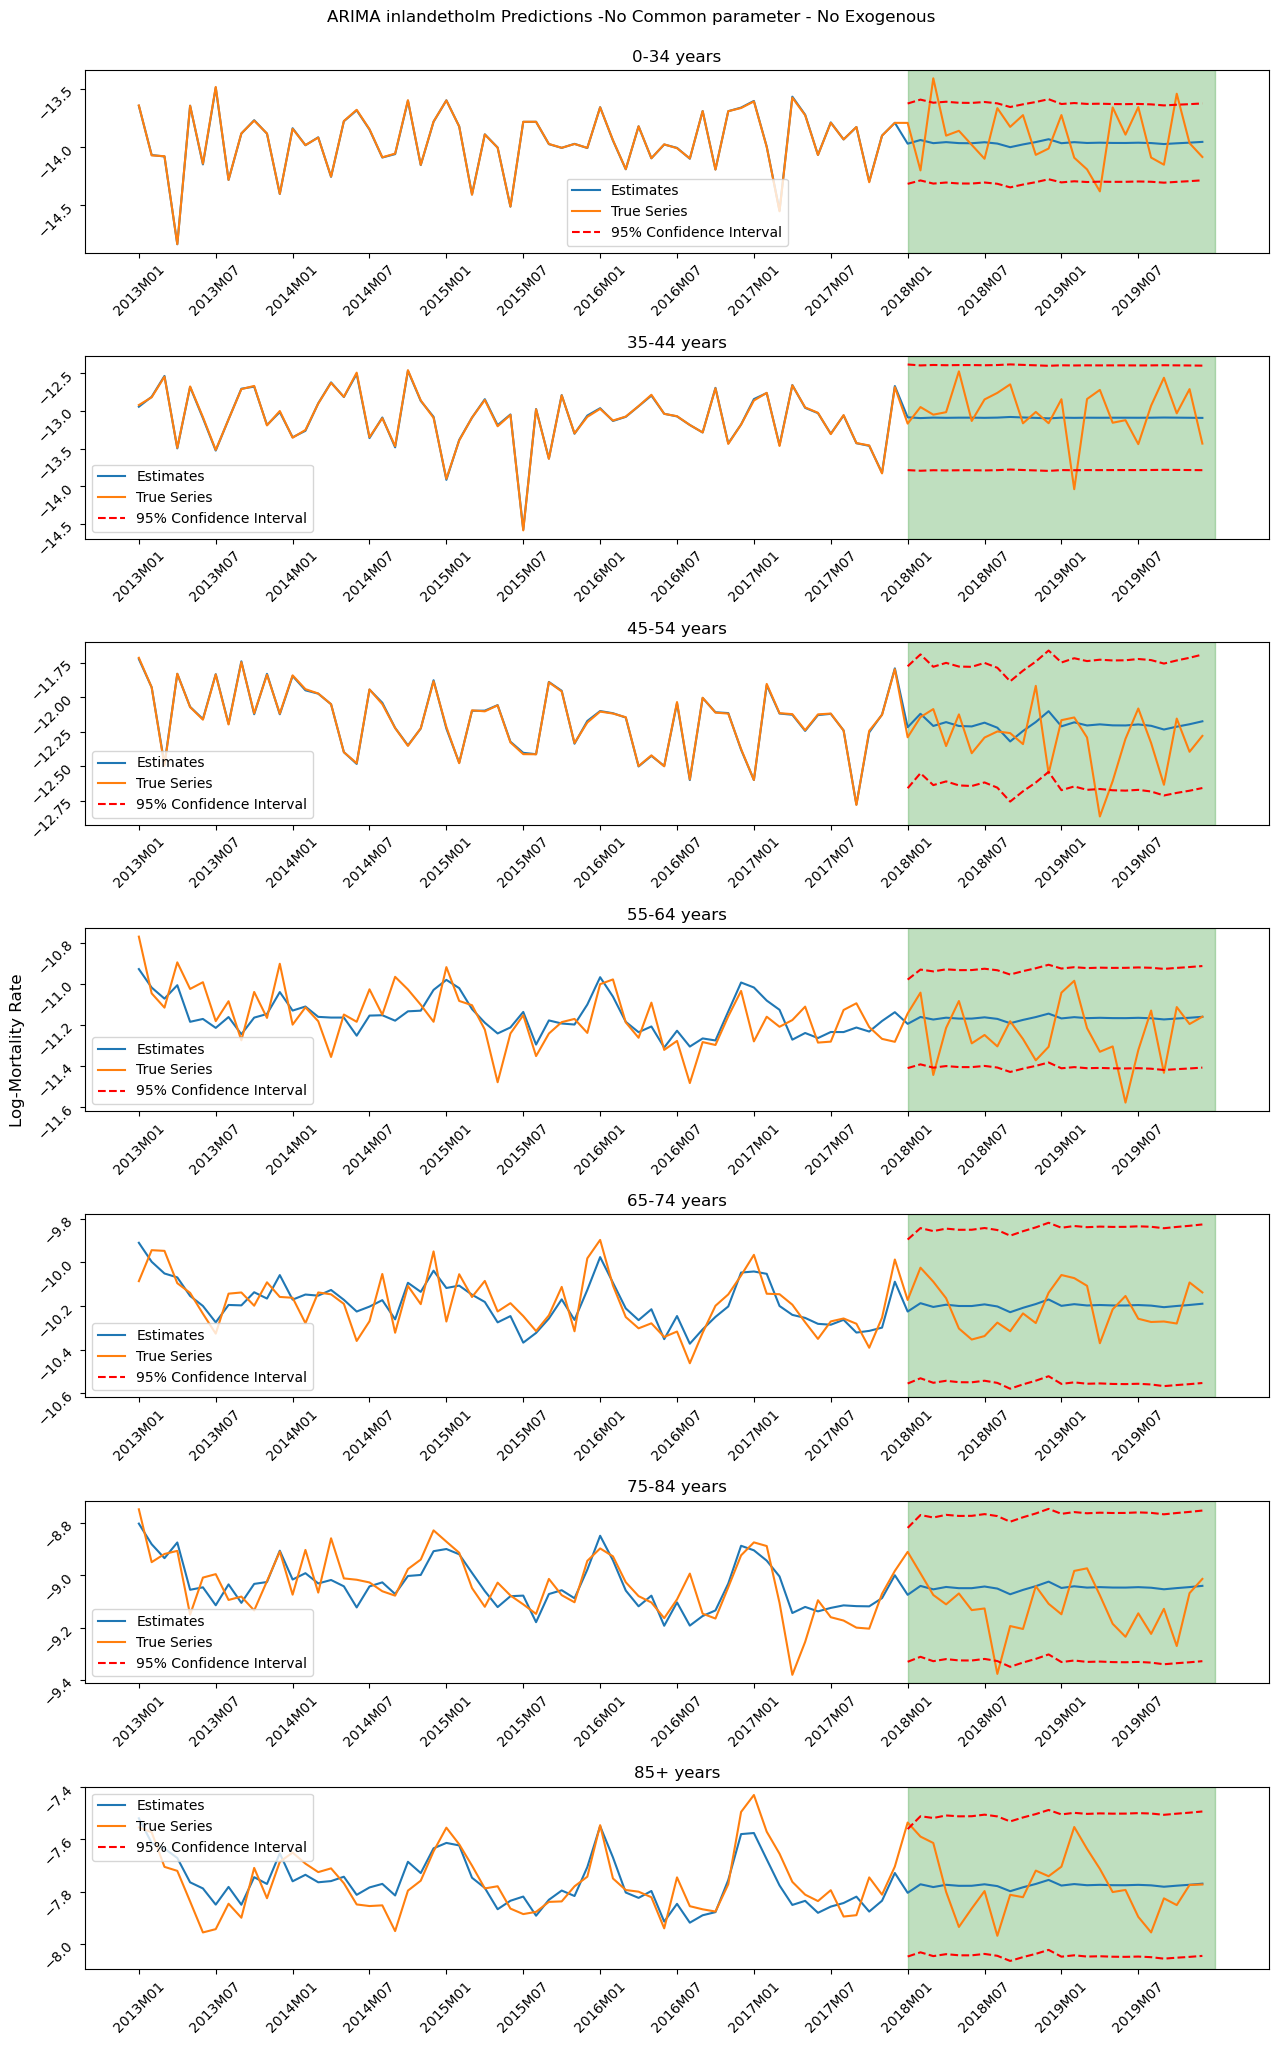

In [44]:
## Model No Common parameter - No Exogenous
a_xi,b_xs,k_ts,regional_re_est,k_t_models,k_t_preds,regional_predictions_nocommout,regional_predictions_upconf,regional_predictions_lowconf,model_error,res,_ = model_no_common(inlandet_logmort_full,regional_terms = 4,prediction_period = 24,train_period = 60,region_deaths = inlandet_death,region_pop = inlandet_pop,re_est = False,smooth = False)

#exogenous_train = exog_train_inlandet,exogenous_test = exog_test_inlandet
regional_predictions_nocommout = pd.DataFrame(regional_predictions_nocommout)
regional_predictions_upconf = pd.DataFrame(regional_predictions_upconf)
regional_predictions_lowconf = pd.DataFrame(regional_predictions_lowconf)

regional_predictions_nocommout.index = inlandet_logmort_full.index
regional_predictions_nocommout.columns = inlandet_logmort_full.columns
regional_predictions_upconf.index = inlandet_logmort_full.index
regional_predictions_upconf.columns = inlandet_logmort_full.columns
regional_predictions_lowconf.index = inlandet_logmort_full.index
regional_predictions_lowconf.columns = inlandet_logmort_full.columns

print("Model Error " + str(model_error))
print("Re_estimation error Each Age Group (MAPE): "+str(MAPE(regional_predictions_nocommout.iloc[:,:60],inlandet_logmort_full.iloc[:,:60])))

#AIC_values = [K_t_models["model_0"].aic(),K_t_models["model_1"].aic(),k_t_models["model_0"].aic(),k_t_models["model_1"].aic()]
#print("\n Model AIC Values [K_t1,K_t2,k_t1,k_t2]: \n"+ str(AIC_values))

print("\n Prediction Error Each Age Group (MAPE)" +str(MAPE(regional_predictions_nocommout.iloc[:,60:],inlandet_logmort_full.iloc[:,60:])))
#print(k_t_models["model_0"].summary())

error_NoCom_wout = MAPE(regional_predictions_nocommout.iloc[:,60:],inlandet_logmort_full.iloc[:,60:])
prediction_plots(regional_predictions_nocommout,regional_predictions_upconf,regional_predictions_lowconf,24,inlandet_logmort_full,suptitle = "ARIMA inlandetholm Predictions -No Common parameter - No Exogenous ")



In [45]:
print(k_t_models['model_0'].summary())
print(k_t_models['model_1'].summary())
print(k_t_models['model_2'].summary())
print(k_t_models['model_3'].summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   60
Model:                        SARIMAX   Log Likelihood                  37.694
Date:                Mon, 15 Jul 2024   AIC                            -73.388
Time:                        14:58:35   BIC                            -71.294
Sample:                             0   HQIC                           -72.569
                                 - 60                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0167      0.002      8.337      0.000       0.013       0.021
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):                29.21
Prob(Q):                              0.69   Pr

p_value k_t0 before re-estimation: 0.5379914664350876 

Regional k_t0 is white noise with LB p_value 0.5379914664350876 

p_value k_t1 before re-estimation: 0.15989534380991344 

Regional k_t1 is white noise with LB p_value 0.15989534380991344 

p_value k_t2 before re-estimation: 0.0005402906937256326 

p_value k_t3 before re-estimation: 1.078577753780616e-06 

p_value k_t0 after re-estimation: 0.5379914664350876 

Regional k_t0 is white noise with LB p_value 0.5379914664350876 

p_value k_t1 after re-estimation: 0.1598953438099137 

Regional k_t1 is white noise with LB p_value 0.1598953438099137 

p_value k_t2 after re-estimation: 0.0005402906937256326 

p_value k_t3 after re-estimation: 1.078577753780616e-06 

Model Error 11.26723298363033
Re_estimation error Each Age Group (MAPE): [0.02081758 0.07675397 0.05041926 1.00443787 0.86823977 0.93184166
 1.27687246]

 Prediction Error Each Age Group (MAPE)[2.08892642 2.85889239 1.60341108 1.3452559  0.75586901 1.28405176
 1.33082643]
     

<Figure size 640x480 with 0 Axes>

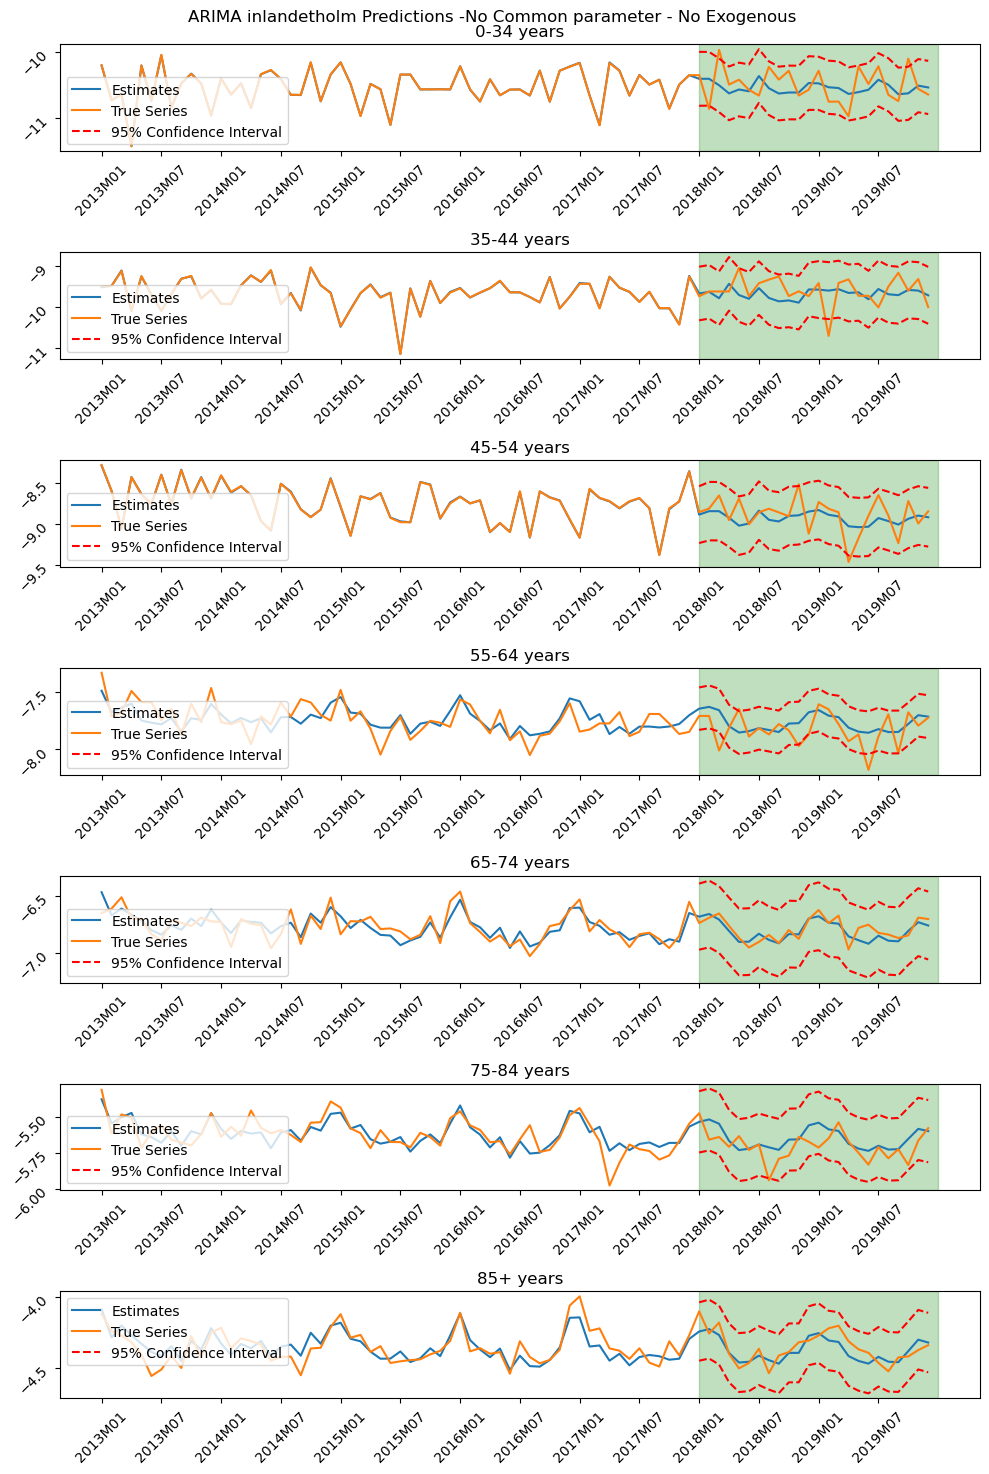

In [27]:
## Model No Common parameter - with Exogenous
a_xi,b_xs,k_ts,regional_re_est,k_t_models,k_t_preds,regional_predictions_nocommwith,regional_predictions_upconf,regional_predictions_lowconf,model_error,res,_ = model_no_common(inlandet_logmort_full,regional_terms = 4,prediction_period = 24,train_period = 60,exogenous_train = exog_train_inlandet,exogenous_test = exog_test_inlandet,region_deaths = inlandet_death,region_pop = inlandet_pop,re_est = False,smooth = False)

#exogenous_train = exog_train_inlandet,exogenous_test = exog_test_inlandet
regional_predictions_nocommwith = pd.DataFrame(regional_predictions_nocommwith)
regional_predictions_upconf = pd.DataFrame(regional_predictions_upconf)
regional_predictions_lowconf = pd.DataFrame(regional_predictions_lowconf)

regional_predictions_nocommwith.index = inlandet_logmort_full.index
regional_predictions_nocommwith.columns = inlandet_logmort_full.columns
regional_predictions_upconf.index = inlandet_logmort_full.index
regional_predictions_upconf.columns = inlandet_logmort_full.columns
regional_predictions_lowconf.index = inlandet_logmort_full.index
regional_predictions_lowconf.columns = inlandet_logmort_full.columns

print("Model Error " + str(model_error))
print("Re_estimation error Each Age Group (MAPE): "+str(MAPE(regional_predictions_nocommwith.iloc[:,:60],inlandet_logmort_full.iloc[:,:60])))

#AIC_values = [K_t_models["model_0"].aic(),K_t_models["model_1"].aic(),k_t_models["model_0"].aic(),k_t_models["model_1"].aic()]
#print("\n Model AIC Values [K_t1,K_t2,k_t1,k_t2]: \n"+ str(AIC_values))

print("\n Prediction Error Each Age Group (MAPE)" +str(MAPE(regional_predictions_nocommwith.iloc[:,60:],inlandet_logmort_full.iloc[:,60:])))
print(k_t_models["model_0"].summary())

error_NoCom_with = MAPE(regional_predictions_nocommwith.iloc[:,60:],inlandet_logmort_full.iloc[:,60:])
prediction_plots(regional_predictions_nocommwith,regional_predictions_upconf,regional_predictions_lowconf,24,inlandet_logmort_full,suptitle = "ARIMA inlandetholm Predictions -No Common parameter - No Exogenous ")



In [28]:
print(k_t_models['model_0'].summary())
print(k_t_models['model_1'].summary())
print(k_t_models['model_2'].summary())
print(k_t_models['model_3'].summary())

                                 SARIMAX Results                                  
Dep. Variable:                          y   No. Observations:                   60
Model:             SARIMAX(0, 0, [1], 12)   Log Likelihood                  42.428
Date:                    Tue, 09 Jul 2024   AIC                            -70.856
Time:                            00:08:27   BIC                            -56.196
Sample:                                 0   HQIC                           -65.122
                                     - 60                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
av_temp        0.0135      0.010      1.409      0.159      -0.005       0.032
av_humid      -0.0008      0.001     -1.105      0.269      -0.002       0.001
temp_below     0.005

# SARIMAX Models pre-COVID With Common terms

Common k_t2 is white noise with LB p_value 0.8983366501621832
p_value k_t0 before re-estimation: 0.8652351638364167 

Regional k_t0 is white noise with LB p_value 0.8652351638364167 

p_value k_t0 after re-estimation: 0.865235163836417 

Regional k_t0 is white noise with LB p_value 0.865235163836417 

Model Error 7.852617356915616
Re_estimation error Each Age Group (MAPE): [1.72231086 0.252572   1.93139116 1.16748441 1.08362263 0.94589251
 1.36060268]

 Prediction Error Each Age Group (MAPE)[2.0301025  4.18714028 1.60378881 1.22487253 1.21572139 1.26559337
 2.26406676]


<Figure size 640x480 with 0 Axes>

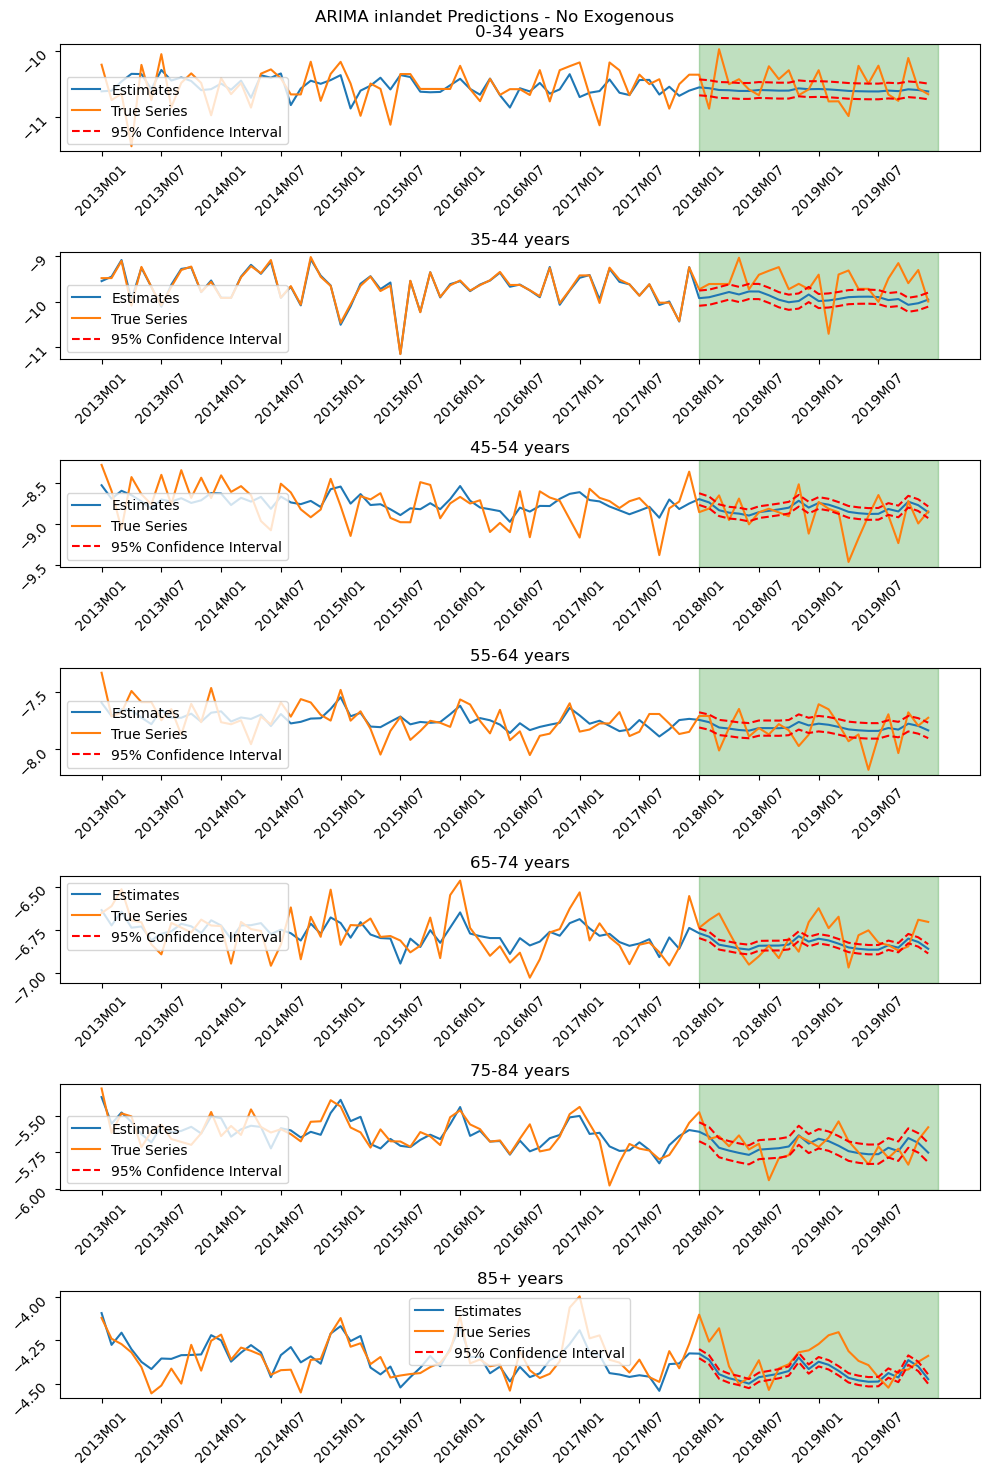

In [26]:
### Without Exogenous
a_xi,B_xs,K_ts,b_xs,k_ts,country_re_est,regional_re_est,K_t_models,k_t_models,K_t_preds,k_t_preds,regional_predictions_sarout,regional_predictions_upconf,regional_predictions_lowconf,model_error,res,_,_ = full_model(all_nor_logmort,inlandet_logmort_full, common_terms = 3,regional_terms = 1,prediction_period = 24,train_period = 60,country_deaths = nor_death, country_pop = nor_pop,region_deaths = inlandet_death,region_pop = inlandet_pop,re_est = False,smooth = False)  


regional_predictions_sarout = pd.DataFrame(regional_predictions_sarout)
regional_predictions_upconf = pd.DataFrame(regional_predictions_upconf)
regional_predictions_lowconf = pd.DataFrame(regional_predictions_lowconf)

regional_predictions_sarout.index = inlandet_logmort_full.index
regional_predictions_sarout.columns = inlandet_logmort_full.columns
regional_predictions_upconf.index = inlandet_logmort_full.index
regional_predictions_upconf.columns = inlandet_logmort_full.columns
regional_predictions_lowconf.index = inlandet_logmort_full.index
regional_predictions_lowconf.columns = inlandet_logmort_full.columns

print("Model Error " + str(model_error))
print("Re_estimation error Each Age Group (MAPE): "+str(MAPE(regional_predictions_sarout.iloc[:,:60],inlandet_logmort_full.iloc[:,:60])))

#AIC_values = [K_t_models["model_0"].aic(),K_t_models["model_1"].aic(),k_t_models["model_0"].aic(),k_t_models["model_1"].aic()]
#print("\n Model AIC Values [K_t1,K_t2,k_t1,k_t2]: \n"+ str(AIC_values))

print("\n Prediction Error Each Age Group (MAPE)" +str(MAPE(regional_predictions_sarout.iloc[:,60:],inlandet_logmort_full.iloc[:,60:])))

error_SARIMAX_wout = MAPE(regional_predictions_sarout.iloc[:,60:],inlandet_logmort_full.iloc[:,60:])
prediction_plots(regional_predictions_sarout,regional_predictions_upconf,regional_predictions_lowconf,24,inlandet_logmort_full,suptitle = "ARIMA inlandet Predictions - No Exogenous")



In [57]:
for mod in K_t_models.keys():
    print(str(K_t_models[mod].get_params()["order"]) + str(K_t_models[mod].get_params()["seasonal_order"]))
    
print("-")

for mod in k_t_models.keys():
    print(str(k_t_models[mod].get_params()["order"]) + str(k_t_models[mod].get_params()["seasonal_order"]))
 



(0, 0, 1)(1, 1, 0, 12)
-
(1, 0, 0)(0, 0, 0, 12)
(0, 0, 0)(2, 0, 0, 12)
(2, 1, 1)(2, 0, 0, 12)
(5, 1, 0)(0, 0, 0, 12)
(0, 0, 0)(0, 0, 0, 12)


Common k_t2 is white noise with LB p_value 0.8983366501621832
Common k_t3 is white noise with LB p_value 0.16801159481304923
p_value k_t0 before re-estimation: 0.8635345644522988 

Regional k_t0 is white noise with LB p_value 0.8635345644522988 

p_value k_t0 after re-estimation: 0.8635345644522988 

Regional k_t0 is white noise with LB p_value 0.8635345644522988 

Re_estimation error Each Age Group (MAPE): [1.71567738 0.27606715 1.74684203 1.16721658 1.03684598 0.90810375
 1.00004554]

 Prediction Error Each Age Group (MAPE)[2.00993824 4.34922324 1.5087384  1.22852957 1.19188616 1.19582396
 1.76522963]


<Figure size 640x480 with 0 Axes>

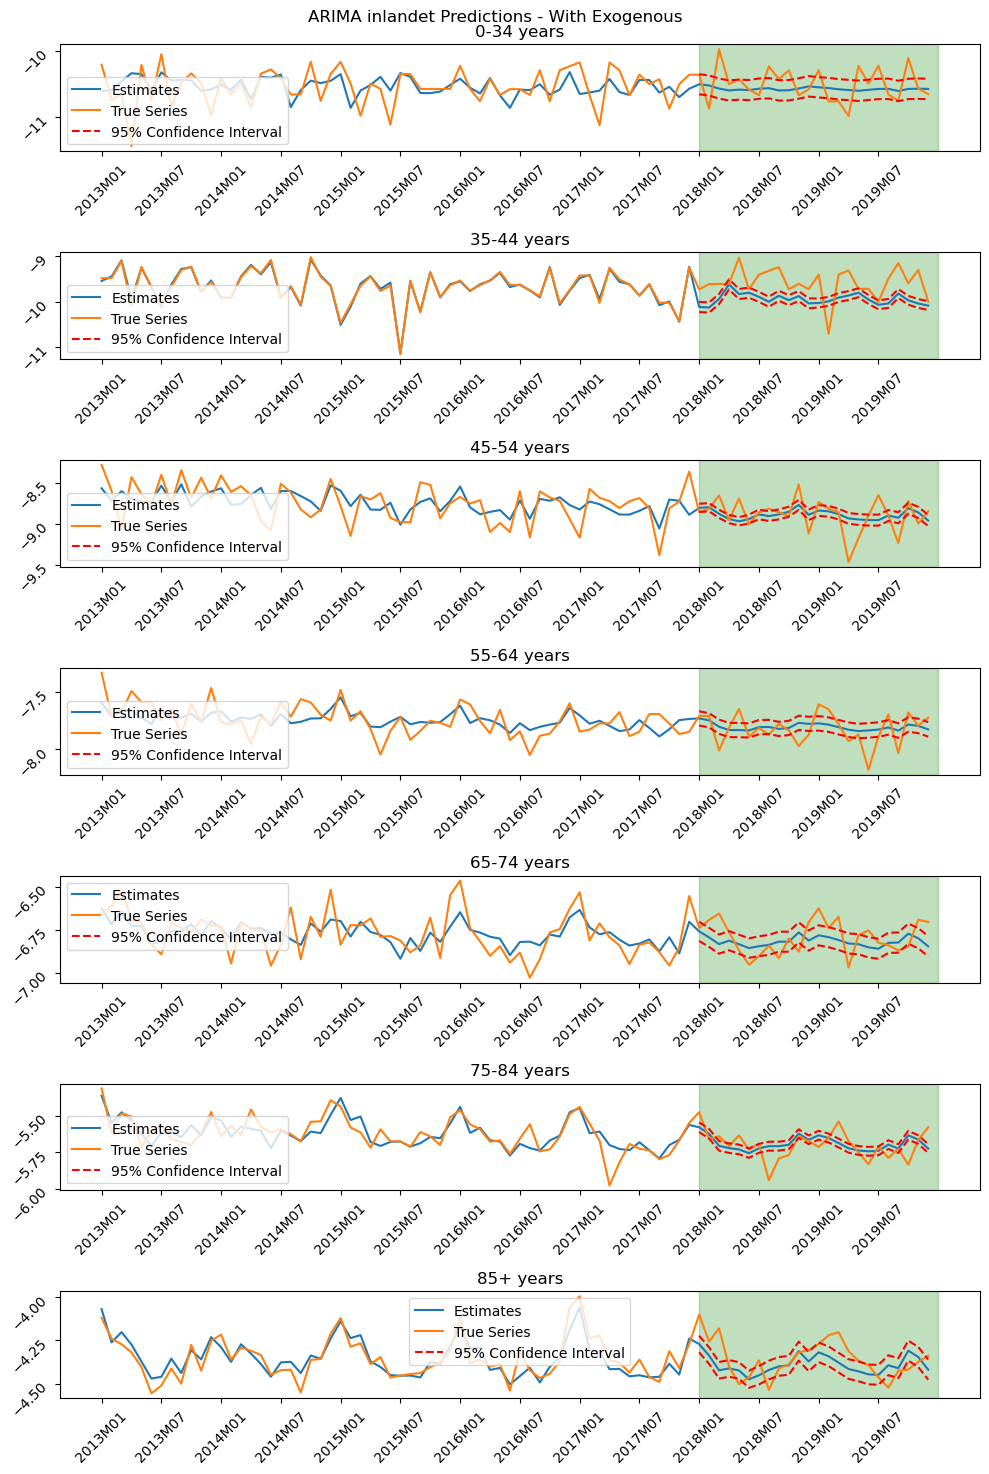

In [21]:
### With Exogenous
a_xi,B_xs,K_ts,b_xs,k_ts,country_re_est,regional_re_est,K_t_models,k_t_models,K_t_preds,k_t_preds,regional_predictions_sarwith,regional_predictions_upconf,regional_predictions_lowconf,model_error,res,_,_ = full_model(all_nor_logmort,inlandet_logmort_full, common_terms = 4,regional_terms = 1,prediction_period = 24,train_period = 60,exogenous_train = exog_train_inlandet,exogenous_test = exog_test_inlandet,country_deaths = nor_death, country_pop = nor_pop,region_deaths = inlandet_death,region_pop = inlandet_pop,re_est = False,smooth=False)  


regional_predictions_sarwith = pd.DataFrame(regional_predictions_sarwith)
regional_predictions_upconf = pd.DataFrame(regional_predictions_upconf)
regional_predictions_lowconf = pd.DataFrame(regional_predictions_lowconf)

regional_predictions_sarwith.index = inlandet_logmort_full.index
regional_predictions_sarwith.columns = inlandet_logmort_full.columns
regional_predictions_upconf.index = inlandet_logmort_full.index
regional_predictions_upconf.columns = inlandet_logmort_full.columns
regional_predictions_lowconf.index = inlandet_logmort_full.index
regional_predictions_lowconf.columns = inlandet_logmort_full.columns

print("Re_estimation error Each Age Group (MAPE): "+str(MAPE(regional_predictions_sarwith.iloc[:,:60],inlandet_logmort_full.iloc[:,:60])))

#AIC_values = [K_t_models["model_0"].aic(),K_t_models["model_1"].aic(),k_t_models["model_0"].aic(),k_t_models["model_1"].aic()]
#print("\n Model AIC Values [K_t1,K_t2,k_t1,k_t2]: \n"+ str(AIC_values))

print("\n Prediction Error Each Age Group (MAPE)" +str(MAPE(regional_predictions_sarwith.iloc[:,60:],inlandet_logmort_full.iloc[:,60:])))

#print(str(k_t_models["model_0"].summary()))
#print(k_t_models["model_1"].summary())
error_SARIMAX_w= MAPE(regional_predictions_sarwith.iloc[:,60:],inlandet_logmort_full.iloc[:,60:])

prediction_plots(regional_predictions_sarwith,regional_predictions_upconf,regional_predictions_lowconf,24,inlandet_logmort_full,suptitle = "ARIMA inlandet Predictions - With Exogenous")



In [60]:
for mod in K_t_models.keys():
    print(str(K_t_models[mod].get_params()["order"]) + str(K_t_models[mod].get_params()["seasonal_order"]))
    
print("-")

for mod in k_t_models.keys():
    print(str(k_t_models[mod].get_params()["order"]) + str(k_t_models[mod].get_params()["seasonal_order"]))
 



(0, 0, 1)(1, 1, 0, 12)
-
(0, 0, 0)(0, 0, 0, 12)


## VARMAX Models

test_errors[1.96015949 2.71851352 2.18109727 1.6004115  1.2096689  1.40982907
 2.01739668]


<Figure size 640x480 with 0 Axes>

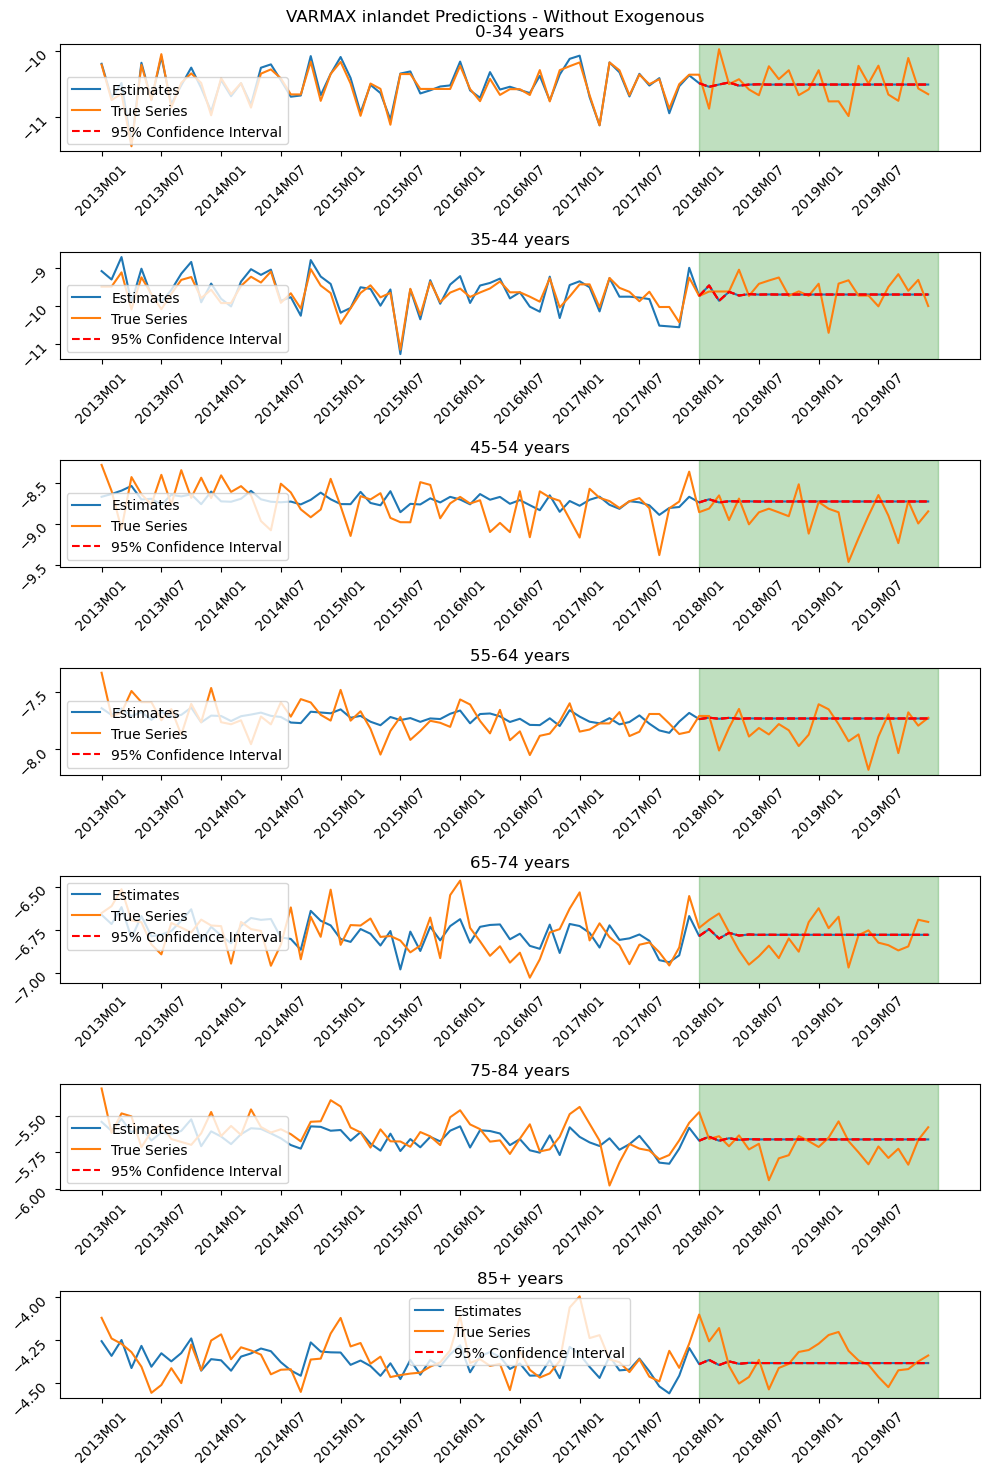

In [22]:
### Without Exogenous
all_k_t, K_ts,k_ts,B_xs,b_xs,a_xi,all_k_preds,predictions_varout,predictions_lowconf,predictions_upconf,model_VAR_wout,aic,error_VAR_wout,_,_ = VARMAX_model(all_nor_logmort,inlandet_logmort_full, common_terms = 1,regional_terms = 2,prediction_period = 24,train_period = 60,AR= 2,MA = 3,country_deaths = nor_death,country_pop = nor_pop,region_deaths = inlandet_death,region_pop = inlandet_pop,re_est = False,smooth = False)

print("test_errors" + str(error_VAR_wout))
prediction_plots(predictions_varout,predictions_varout,predictions_varout,24,inlandet_logmort_full,suptitle = "VARMAX inlandet Predictions - Without Exogenous")



test_errors[2.22406964 3.24465311 2.64663497 1.67621413 0.95193539 1.45924493
 1.61111895]


<Figure size 640x480 with 0 Axes>

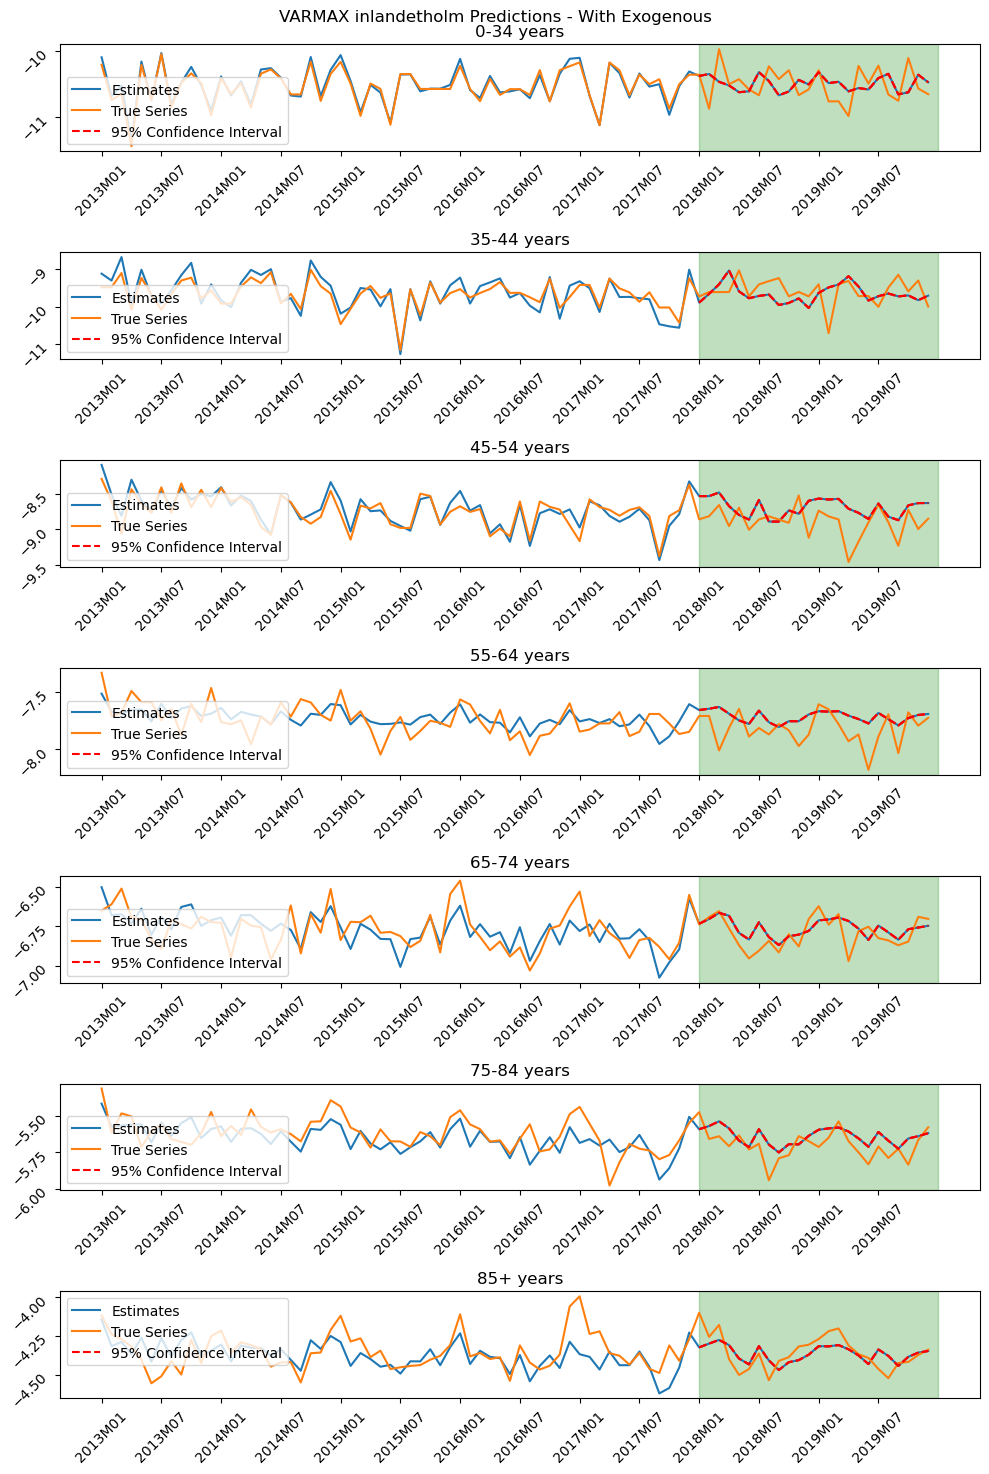

In [23]:
### With Exogenous
all_k_t, K_ts,k_ts,B_xs,b_xs,a_xi,all_k_preds,predictions_varwith,predictions_lowconf,predictions_upconf,model_VAR_with,aic,error_VAR_w,_,_ = VARMAX_model(all_nor_logmort,inlandet_logmort_full, common_terms = 1,regional_terms = 3,prediction_period = 24,train_period = 60,AR= 2,MA = 2,exogenous_train = exog_train_inlandet,exogenous_test = exog_test_inlandet,country_deaths = nor_death,country_pop = nor_pop,region_deaths = inlandet_death,region_pop = inlandet_pop,re_est = False)

print("test_errors" + str(error_VAR_w))
prediction_plots(predictions_varwith,predictions_varwith,predictions_varwith,24,inlandet_logmort_full,suptitle = "VARMAX inlandetholm Predictions - With Exogenous")



In [42]:
model_VAR_with.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             Statespace Model Results                            
=================================================================================
Dep. Variable:     [0, 1, 2, 3, 4, 5, 6]   No. Observations:                   60
Model:                       VARMAX(2,5)   Log Likelihood                 191.136
                             + intercept   AIC                            443.727
Date:                   Wed, 12 Jun 2024   BIC                           1308.691
Time:                           11:57:50   HQIC                           782.062
Sample:                                0                                         
                                    - 60                                         
Covariance Type:                     opg                                         
===============================================================================================================================
Ljung-Box (L1) (Q):     0.45, 5.37, 4.92, 0.57, 0.00, 0.02, 0.15   Jarque-Bera (JB):   0.91, 2.75, 1.97, 0.78, 0.22, 0.37, 0.20
Prob(Q):                0.50, 0.02, 0.03, 0.45, 0.99, 0.89, 0.70   Prob(JB):           0.63, 0.25, 0.37, 0.68, 0.90, 0.83, 0.91
Heteroskedasticity (H): 0.98, 1.71, 1.26, 0.97, 1.52, 1.70, 1.60   Skew:               0.30, 0.42, 0.24, 0.19, 0.06, 0.19, 0.07
Prob(H) (two-sided):    0.97, 0.24, 0.61, 0.95, 0.36, 0.24, 0.30   Kurtosis:           3.01, 2.36, 2.26, 2.60, 3.27, 2.90, 2.75
                               Results for equation 0                              
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
intercept          -0.1934      0.002   -104.484      0.000      -0.197      -0.190
L1.0                0.1206      0.004     34.378      0.000       0.114       0.128
L1.1               -0.0376      0.007     -5.153      0.000      -0.052      -0.023
L1.2                0.0303      0.004      8.642      0.000       0.023       0.037
L1.3               -0.1976      0.005    -43.061      0.000      -0.207      -0.189
L1.4                0.1775      0.003     56.833      0.000       0.171       0.184
L1.5                0.0411      0.004      9.975      0.000       0.033       0.049
L1.6                0.0035      0.003      1.211      0.226      -0.002       0.009
L2.0                0.4342      0.048      9.036      0.000       0.340       0.528
L2.1               -0.0444      0.011     -4.188      0.000      -0.065      -0.024
L2.2               -0.2047      0.004    -53.990      0.000      -0.212      -0.197
L2.3                0.2528      0.025      9.946      0.000       0.203       0.303
L2.4               -0.2768      0.043     -6.474      0.000      -0.361      -0.193
L2.5               -0.3596      0.057     -6.327      0.000      -0.471      -0.248
L2.6                0.4821      0.041     11.690      0.000       0.401       0.563
L1.e(0)            -0.1988      0.006    -31.643      0.000      -0.211      -0.186
L1.e(1)             0.1474      0.012     12.637      0.000       0.125       0.170
L1.e(2)             0.0347      0.043      0.800      0.424      -0.050       0.120
L1.e(3)            -0.0152      0.017     -0.904      0.366      -0.048       0.018
L1.e(4)             0.3218      0.013     25.075      0.000       0.297       0.347
L1.e(5)             0.4506      0.024     19.056      0.000       0.404       0.497
L1.e(6)            -0.2768      0.006    -45.158      0.000      -0.289      -0.265
L2.e(0)             0.1584      0.028      5.564      0.000       0.103       0.214
L2.e(1)            -0.1616      0.014    -11.749      0.000      -0.189      -0.135
L2.e(2)             0.2086      0.016     12.650      0.000       0.176       0.241
L2.e(3)             0.1777      0.047      3.795      0.

In [16]:
all_nor_logmort.index

Index(['0-34 years', '35-44 years', '45-54 years', '55-64 years',
       '65-74 years', '75-84 years', '85+ years'],
      dtype='object', name='Age_band')

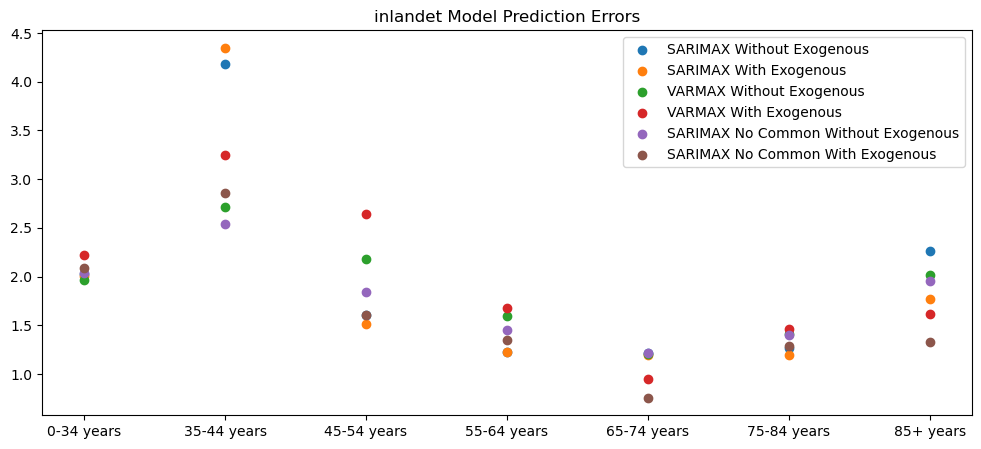

In [24]:
test_errors = np.vstack((error_SARIMAX_wout,error_SARIMAX_w,error_VAR_wout,error_VAR_w,error_NoCom_wout,error_NoCom_with))
inlandet = test_errors

age_groups = all_nor_logmort.index
plt.figure(figsize = (12,5))
plt.scatter(age_groups,inlandet[0,:],label = "SARIMAX Without Exogenous")
plt.scatter(age_groups,inlandet[1,:],label = "SARIMAX With Exogenous")
plt.scatter(age_groups,inlandet[2,:],label = "VARMAX Without Exogenous")
plt.scatter(age_groups,inlandet[3,:],label = "VARMAX With Exogenous")
plt.scatter(age_groups,inlandet[4,:],label = "SARIMAX No Common Without Exogenous")
plt.scatter(age_groups,inlandet[5,:],label = "SARIMAX No Common With Exogenous")
plt.legend();
plt.title("inlandet Model Prediction Errors");

In [25]:
np.mean(inlandet,axis = 1)

array([1.97018366, 1.89276703, 1.87101092, 1.97341016, 1.77683937,
       1.60960471])

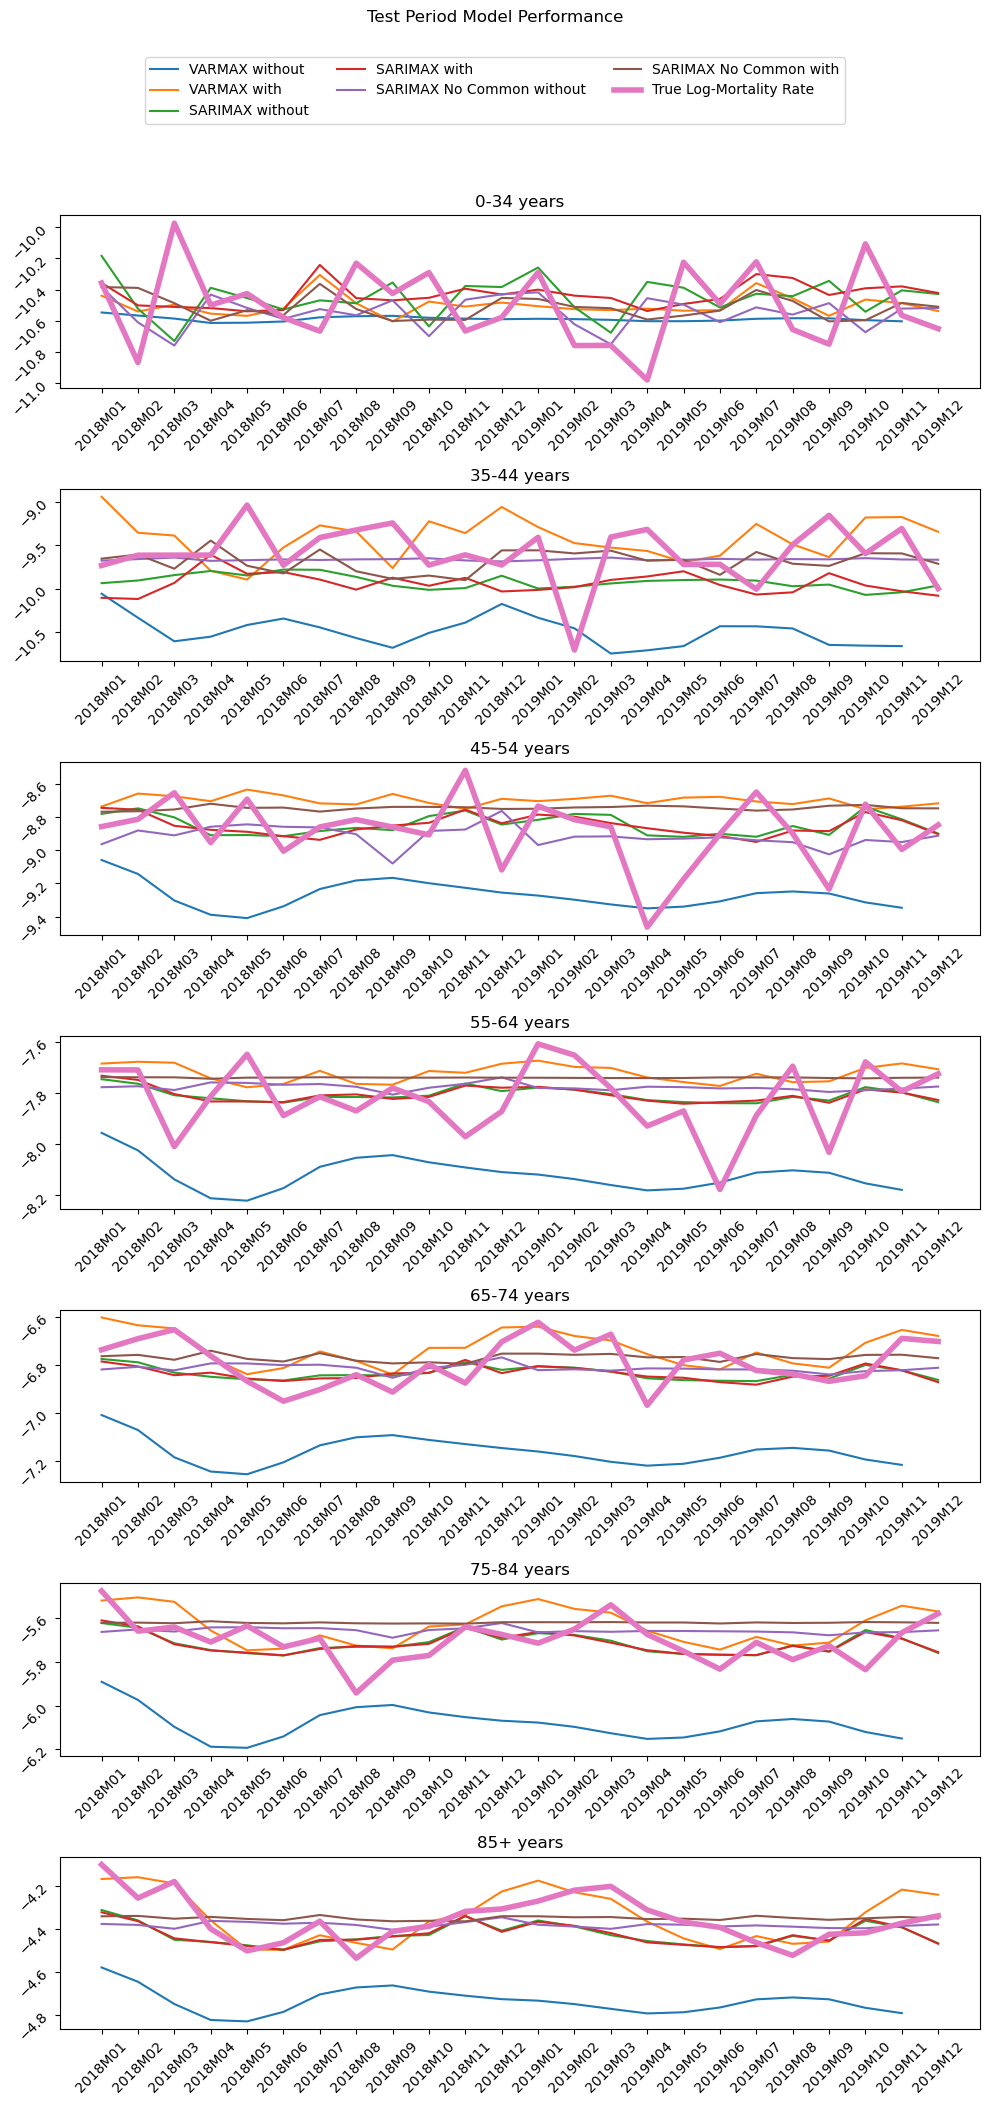

In [13]:
predictions_varwith = pd.DataFrame(predictions_varwith)
predictions_varwith.index = inlandet_logmort_full.index
predictions_varwith.columns = inlandet_logmort_full.columns

predictions_varout = pd.DataFrame(predictions_varout)
predictions_varout.index = inlandet_logmort_full.index
predictions_varout.columns = inlandet_logmort_full.columns


age_groups = all_nor_logmort.index
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(10, 20))

# Store lines and labels to create a single legend
lines = []
labels = []

for row in range(7):
    age = age_groups[row]
    axes[row].set_title(age)
    
    line1, = axes[row].plot(predictions_varout.iloc[row, 60:], label="VARMAX without")
    line2, = axes[row].plot(predictions_varwith.iloc[row, 60:], label="VARMAX with")
    line3, = axes[row].plot(regional_predictions_sarout.iloc[row, 60:], label="SARIMAX without")
    line4, = axes[row].plot(regional_predictions_sarwith.iloc[row, 60:], label="SARIMAX with")
    line5, = axes[row].plot(regional_predictions_nocommout.iloc[row, 60:], label="SARIMAX No Common without")
    line6, = axes[row].plot(regional_predictions_nocommwith.iloc[row, 60:], label="SARIMAX No Common with")
    line7, = axes[row].plot(inlandet_logmort_full.iloc[row, 60:], label="True Log-Mortality Rate", linewidth=4)
    
    axes[row].tick_params(rotation=45)
    
    # Collect lines and labels for the legend
    if row == 0:
        lines.extend([line1, line2, line3, line4, line5, line6, line7])
        labels.extend([line.get_label() for line in lines])

# Create a single legend
fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=3)
plt.suptitle("Test Period Model Performance", y=1.05)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

# COVID Period Modelling

p_value k_t0 before re-estimation: 0.6641922888318661 

Regional k_t0 is white noise with LB p_value 0.6641922888318661 

p_value k_t1 before re-estimation: 0.24293387045881074 

Regional k_t1 is white noise with LB p_value 0.24293387045881074 

p_value k_t2 before re-estimation: 1.7019611081113348e-16 

p_value k_t3 before re-estimation: 9.869726109459076e-37 

Proportion of k_t values which are positive[0.47619048 0.52380952 0.48809524 0.57142857] 

Proportion of b_x values which are positive[0.57142857 0.57142857 0.14285714 0.28571429] 

p_value k_t0 after re-estimation: 0.3395173515325809 

Regional k_t0 is white noise with LB p_value 0.3395173515325809 

p_value k_t1 after re-estimation: 0.0859732591618551 

Regional k_t1 is white noise with LB p_value 0.0859732591618551 

p_value k_t2 after re-estimation: 1.7717650848854002e-09 

p_value k_t3 after re-estimation: 5.8001153607289274e-12 

Model Error 9.789929485890108
Re_estimation error Each Age Group (MAPE): [0.02992544 0.042370

<Figure size 640x480 with 0 Axes>

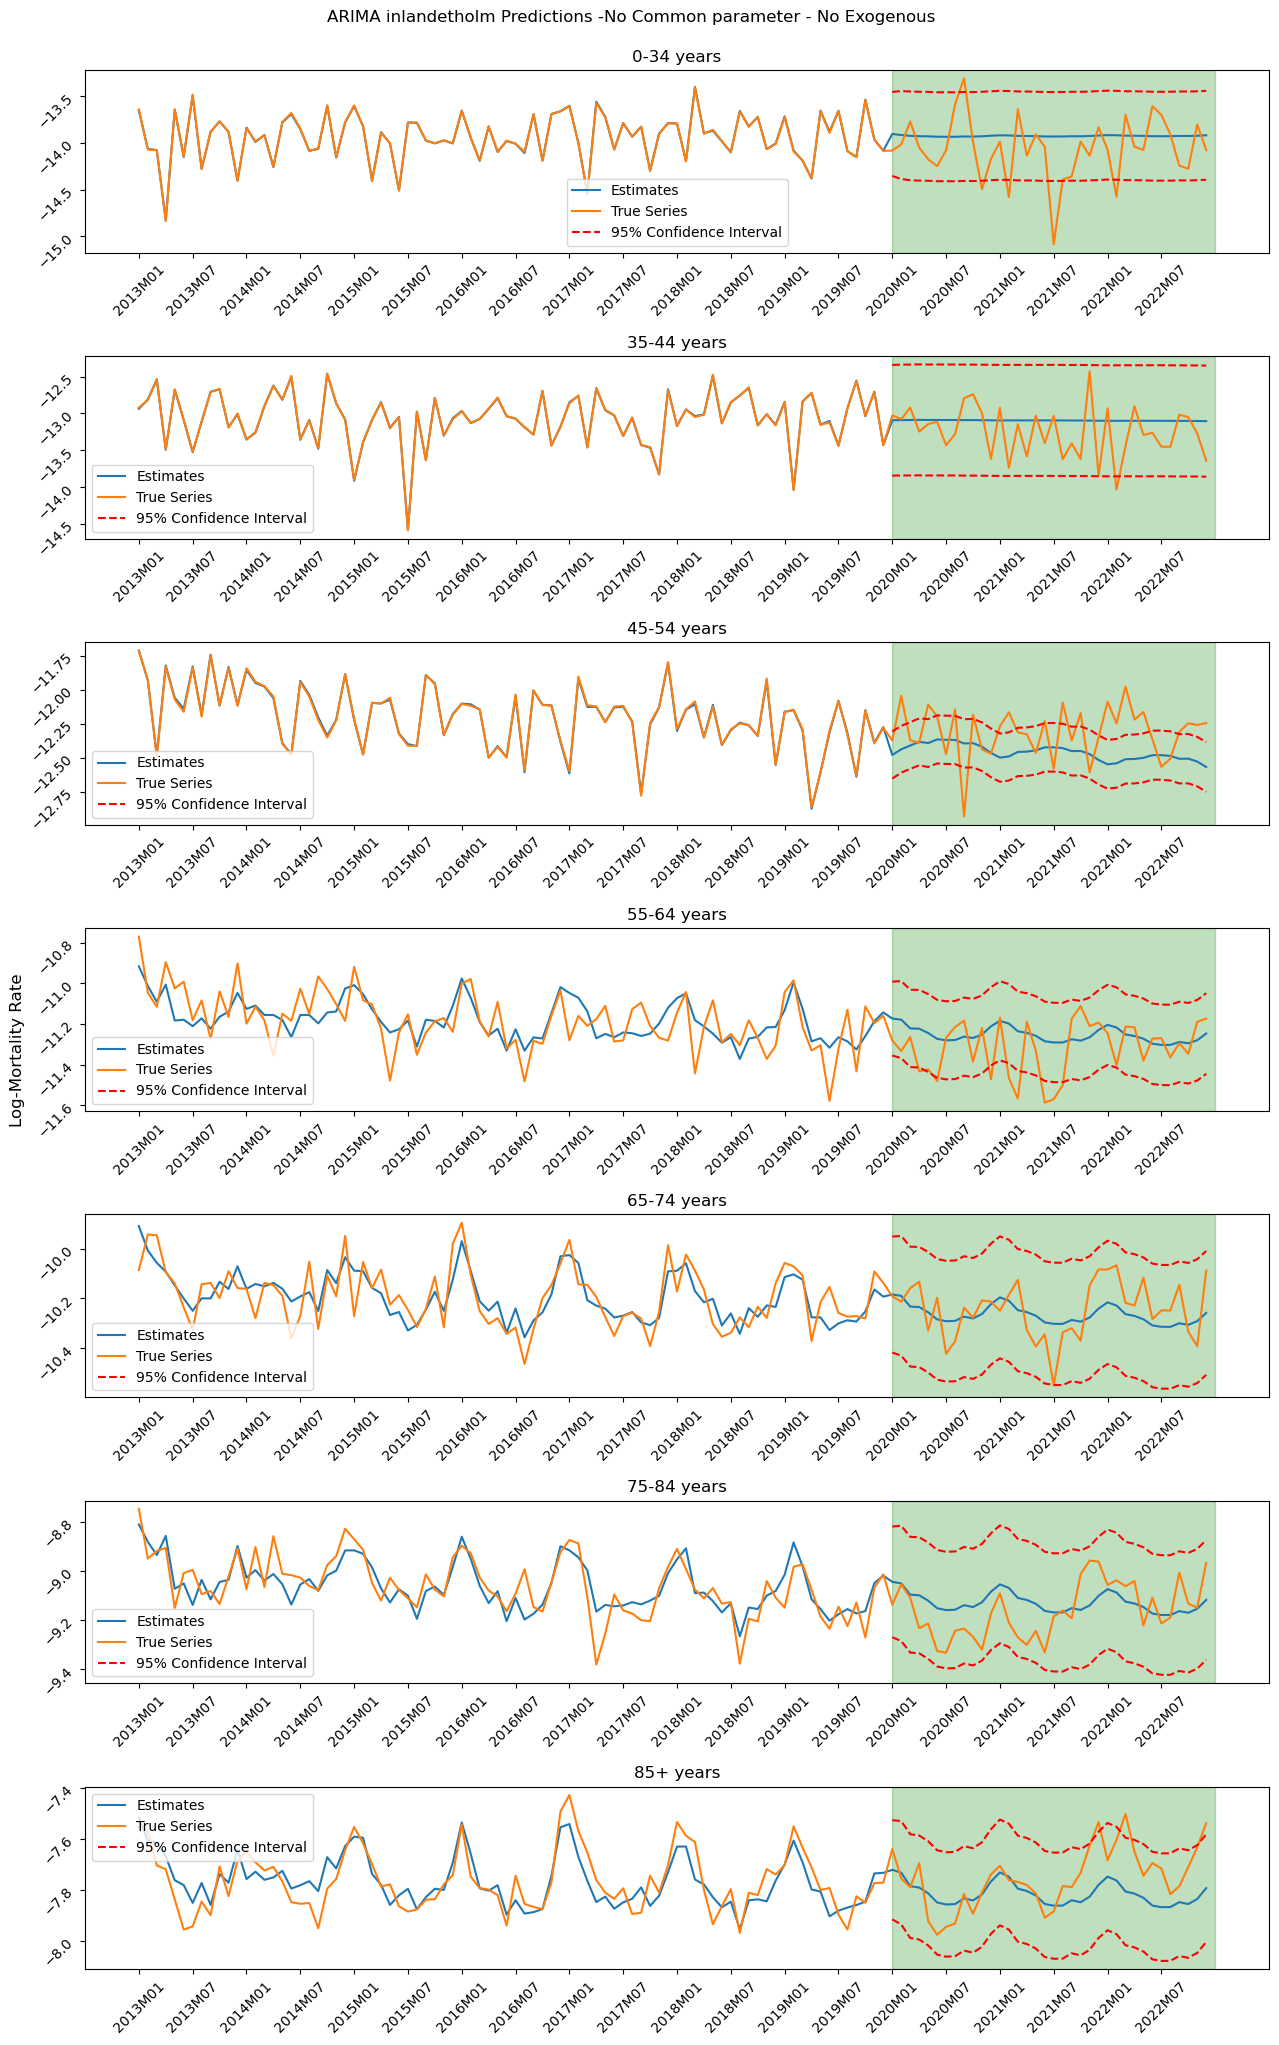

In [46]:
## Model No Common parameter - No Exogenous
a_xi,b_xs,k_ts,regional_re_est,k_t_models,k_t_preds,regional_predictions_nocommoutCOVID,regional_predictions_upconf,regional_predictions_lowconf,model_error,res,D = model_no_common(inlandet_logmort_incCOVID,regional_terms = 4,prediction_period = 36,train_period = 84,region_deaths = inlandet_death_COVID,region_pop = inlandet_pop_COVID,re_est = False,smooth = False)

#exogenous_train = exog_train_inlandet,exogenous_test = exog_test_inlandet
regional_predictions_nocommoutCOVID = pd.DataFrame(regional_predictions_nocommoutCOVID)
regional_predictions_upconf = pd.DataFrame(regional_predictions_upconf)
regional_predictions_lowconf = pd.DataFrame(regional_predictions_lowconf)

regional_predictions_nocommoutCOVID.index = inlandet_logmort_incCOVID.index
regional_predictions_nocommoutCOVID.columns = inlandet_logmort_incCOVID.columns
regional_predictions_upconf.index = inlandet_logmort_incCOVID.index
regional_predictions_upconf.columns = inlandet_logmort_incCOVID.columns
regional_predictions_lowconf.index = inlandet_logmort_incCOVID.index
regional_predictions_lowconf.columns = inlandet_logmort_incCOVID.columns

print("Model Error " + str(model_error))
print("Re_estimation error Each Age Group (MAPE): "+str(MAPE(regional_predictions_nocommoutCOVID.iloc[:,:84],inlandet_logmort_incCOVID.iloc[:,:84])))

#AIC_values = [K_t_models["model_0"].aic(),K_t_models["model_1"].aic(),k_t_models["model_0"].aic(),k_t_models["model_1"].aic()]
#print("\n Model AIC Values [K_t1,K_t2,k_t1,k_t2]: \n"+ str(AIC_values))

print("\n Prediction Error Each Age Group (MAPE)" +str(MAPE(regional_predictions_nocommoutCOVID.iloc[:,84:],inlandet_logmort_incCOVID.iloc[:,84:])))
#print(k_t_models["model_0"].summary())

#inlandet_pop_inCOVID = undo_person_days(pd.DataFrame(inlandet_pop_inCOVID,columns = inlandet_logmort_incCOVID.columns[-36:]))

exp_term = np.multiply(np.exp(a_xi+b_xs@np.diag(D)[:4,:4]@k_t_preds[:,84:]),inlandet_pop_inCOVID) ### Add scaling of singular values
exp_term = np.round(exp_term,0)
pred_total_deaths = np.sum(exp_term,axis = 1)
actual_total_deaths = np.sum(inlandet_death_inCOVID,axis = 1)

error_NoCom_woutCOVID = MAPE(regional_predictions_nocommoutCOVID.iloc[:,84:],inlandet_logmort_incCOVID.iloc[:,84:])
prediction_plots(regional_predictions_nocommoutCOVID,regional_predictions_upconf,regional_predictions_lowconf,36,inlandet_logmort_incCOVID,suptitle = "ARIMA inlandetholm Predictions -No Common parameter - No Exogenous ")



In [47]:
inlandet_NoCom_NoExog_deaths_20 = pd.DataFrame(exp_term).iloc[:,:6].sum(axis = 1) #only first half of 2020
inlandet_NoCom_NoExog_deaths_20_21 = epi_year(pd.DataFrame(exp_term))["year_0"].sum(axis = 1)
inlandet_NoCom_NoExog_deaths_21_22 = epi_year(pd.DataFrame(exp_term))["year_1"].sum(axis = 1)
inlandet_NoCom_NoExog_deaths_22 = epi_year(pd.DataFrame(exp_term))["year_2"].sum(axis = 1)

p_value k_t0 before re-estimation: 0.6641922888318661 

Regional k_t0 is white noise with LB p_value 0.6641922888318661 

p_value k_t1 before re-estimation: 0.24293387045881074 

Regional k_t1 is white noise with LB p_value 0.24293387045881074 

p_value k_t2 before re-estimation: 1.7019611081113348e-16 

p_value k_t3 before re-estimation: 9.869726109459076e-37 

Proportion of k_t values which are positive[0.47619048 0.52380952 0.48809524 0.57142857] 

Proportion of b_x values which are positive[0.57142857 0.57142857 0.14285714 0.28571429] 

p_value k_t0 after re-estimation: 0.3395173515325809 

Regional k_t0 is white noise with LB p_value 0.3395173515325809 

p_value k_t1 after re-estimation: 0.0859732591618551 

Regional k_t1 is white noise with LB p_value 0.0859732591618551 

p_value k_t2 after re-estimation: 1.7717650848854002e-09 

p_value k_t3 after re-estimation: 5.8001153607289274e-12 

Model Error 9.476796520153702
Re_estimation error Each Age Group (MAPE): [0.02992544 0.042370

<Figure size 640x480 with 0 Axes>

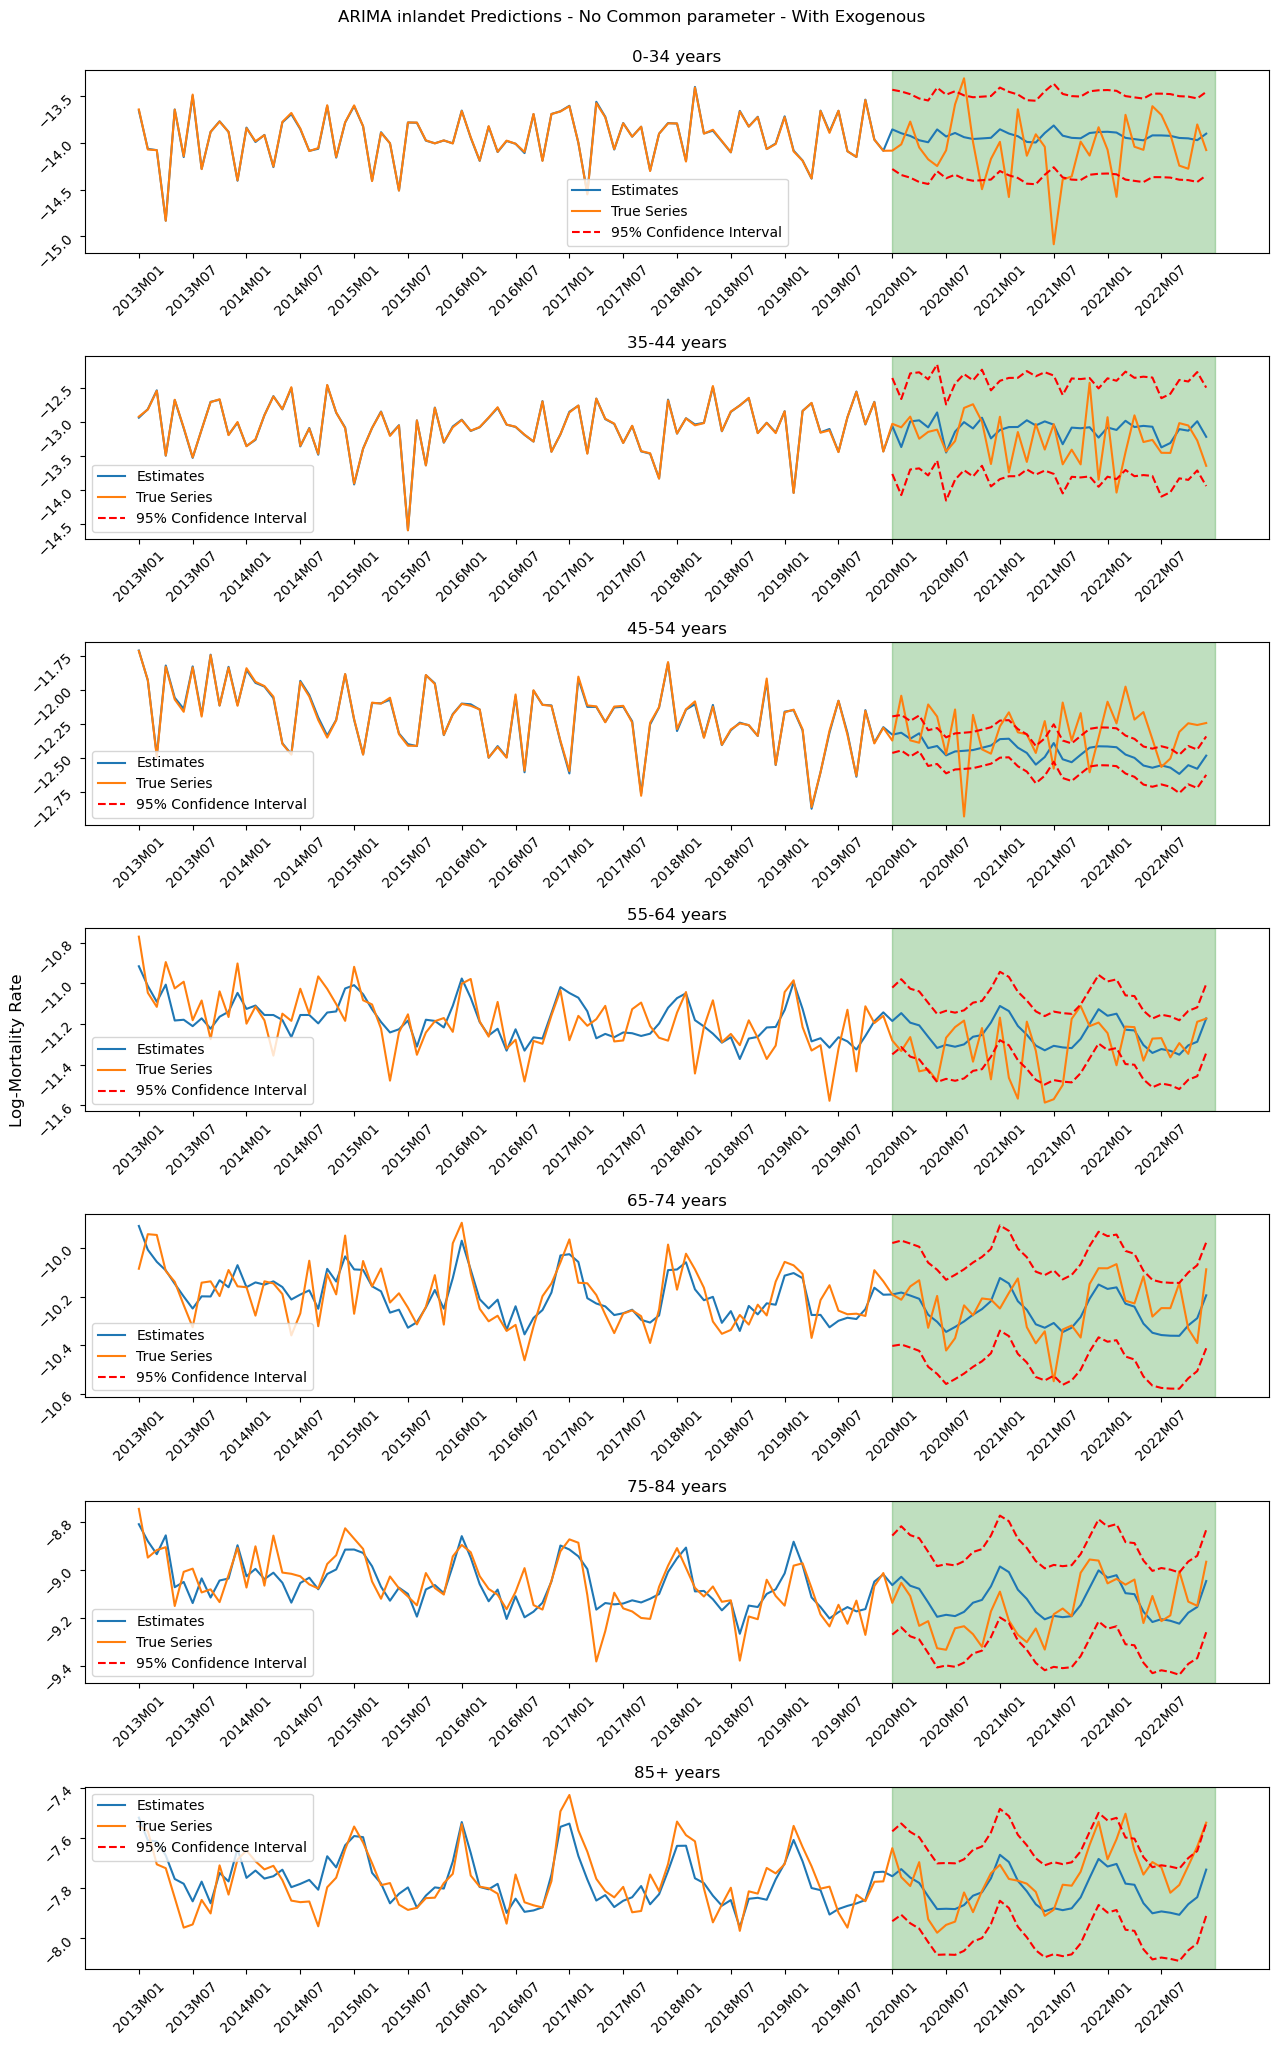

In [48]:
## Model No nocommon parameter - With Exogenous
a_xi,b_xs,k_ts,regional_re_est,k_t_models,k_t_preds,regional_predictions_nocommwithCOVID,regional_predictions_upconf,regional_predictions_lowconf,model_error,res,D = model_no_common(inlandet_logmort_incCOVID,regional_terms = 4,prediction_period = 36,train_period = 84,exogenous_train = exog_train_inlandet_COVID,exogenous_test = exog_test_inlandet_COVID,region_deaths = inlandet_death_COVID,region_pop = inlandet_pop_COVID,re_est = False,smooth = False)

#exogenous_train = exog_train_inlandet,exogenous_test = exog_test_inlandet
regional_predictions_nocommwithCOVID = pd.DataFrame(regional_predictions_nocommwithCOVID)
regional_predictions_upconf = pd.DataFrame(regional_predictions_upconf)
regional_predictions_lowconf = pd.DataFrame(regional_predictions_lowconf)

regional_predictions_nocommwithCOVID.index = inlandet_logmort_incCOVID.index
regional_predictions_nocommwithCOVID.columns = inlandet_logmort_incCOVID.columns
regional_predictions_upconf.index = inlandet_logmort_incCOVID.index
regional_predictions_upconf.columns = inlandet_logmort_incCOVID.columns
regional_predictions_lowconf.index = inlandet_logmort_incCOVID.index
regional_predictions_lowconf.columns = inlandet_logmort_incCOVID.columns

print("Model Error " + str(model_error))
print("Re_estimation error Each Age Group (MAPE): "+str(MAPE(regional_predictions_nocommwithCOVID.iloc[:,:84],inlandet_logmort_incCOVID.iloc[:,:84])))

#AIC_values = [K_t_models["model_0"].aic(),K_t_models["model_1"].aic(),k_t_models["model_0"].aic(),k_t_models["model_1"].aic()]
#print("\n Model AIC Values [K_t1,K_t2,k_t1,k_t2]: \n"+ str(AIC_values))

print("\n Prediction Error Each Age Group (MAPE)" +str(MAPE(regional_predictions_nocommwithCOVID.iloc[:,84:],inlandet_logmort_incCOVID.iloc[:,84:])))
#print(k_t_models["model_0"].summary())

#inlandet_pop_inCOVID = undo_person_days(pd.DataFrame(inlandet_pop_inCOVID,columns = inlandet_logmort_incCOVID.columns[-36:]))

exp_term = np.multiply(np.exp(a_xi+ b_xs@np.diag(D)[:4,:4]@k_t_preds[:,84:]),inlandet_pop_inCOVID) ### Add scaling of singular values
exp_term = np.round(exp_term,0)
pred_total_deaths = np.sum(exp_term,axis = 1)
actual_total_deaths = np.sum(inlandet_death_inCOVID,axis = 1)



error_NoCom_withCOVID = MAPE(regional_predictions_nocommwithCOVID.iloc[:,84:],inlandet_logmort_incCOVID.iloc[:,84:])
prediction_plots(regional_predictions_nocommwithCOVID,regional_predictions_upconf,regional_predictions_lowconf,36,inlandet_logmort_incCOVID,suptitle = "ARIMA inlandet Predictions - No Common parameter - With Exogenous ")



In [49]:
inlandet_NoCom_WithExog_deaths_20 = pd.DataFrame(exp_term).iloc[:,:6].sum(axis = 1) #only first half of 2020
inlandet_NoCom_WithExog_deaths_20_21 = epi_year(pd.DataFrame(exp_term))["year_0"].sum(axis = 1)
inlandet_NoCom_WithExog_deaths_21_22 = epi_year(pd.DataFrame(exp_term))["year_1"].sum(axis = 1)
inlandet_NoCom_WithExog_deaths_22 = epi_year(pd.DataFrame(exp_term))["year_2"].sum(axis = 1)

p_value k_t0 before re-estimation: 3.8316351380325134e-19 

p_value k_t0 after re-estimation: 3.8316351380325134e-19 

Model Error 5.027252513971216
Re_estimation error Each Age Group (MAPE): [1.43417228 1.80657556 1.38736365 0.81995101 0.71171438 0.64758013
 0.76328856]

 Prediction Error Each Age Group (MAPE)[1.76826625 1.98534424 1.18498457 0.99229329 0.82041221 1.05600133
 1.6895008 ]

Predicted number of deaths for COVID period [  432.   289.   778.  2026.  4889.  8834. 12212.]
Actual number of deaths for COVID period [  417   272   751  1885  4859  8640 13169]
Actual deaths over predicted deaths [0.96527778 0.94117647 0.96529563 0.93040474 0.99386378 0.97803939
 1.07836554]
Total Excess Mortality (Actual - Predicted): -533.0
Excess Mortality Ratio (Actual/Predicted): 0.9822291868102557


<Figure size 640x480 with 0 Axes>

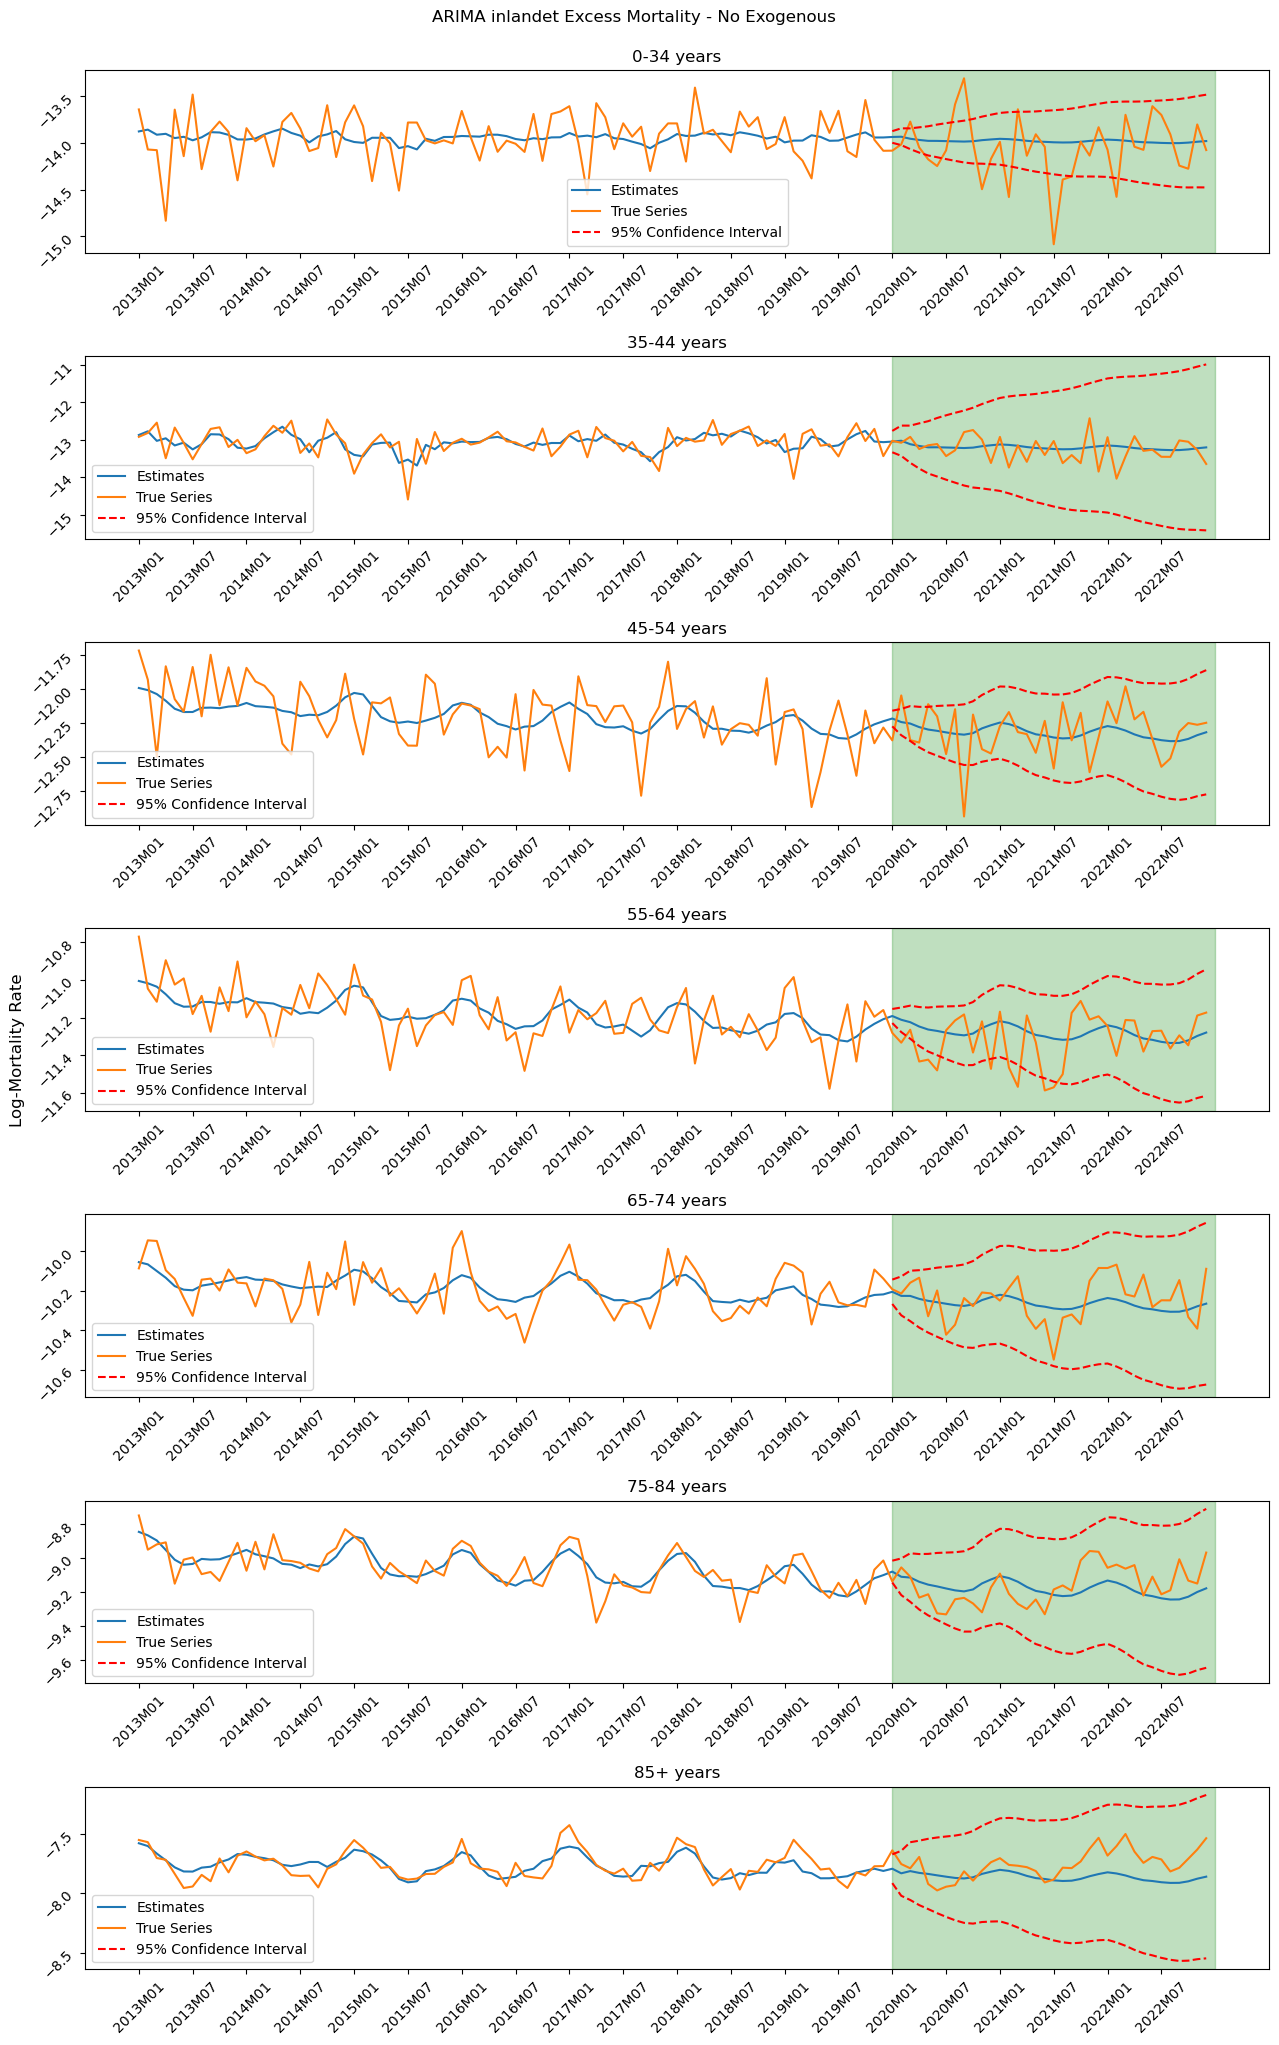

In [50]:
### Without Exogenous 2 common 4 regional 
### Without Exogenous
a_xi,B_xs,K_ts,b_xs,k_ts,country_re_est,regional_re_est,K_t_models,k_t_models_sarout,K_t_preds,k_t_preds,regional_predictions_saroutCOVID,regional_predictions_upconf,regional_predictions_lowconf,model_error,res,_,_ = full_model(all_nor_logmort_incCOVID,inlandet_logmort_incCOVID, common_terms = 2,regional_terms = 1,prediction_period = 36,train_period = 84,country_deaths = nor_death_COVID, country_pop = nor_pop_COVID,region_deaths = inlandet_death_COVID,region_pop = inlandet_pop_COVID,re_est = False,smooth = True)  


regional_predictions_saroutCOVID = pd.DataFrame(regional_predictions_saroutCOVID)
regional_predictions_upconf = pd.DataFrame(regional_predictions_upconf)
regional_predictions_lowconf = pd.DataFrame(regional_predictions_lowconf)

regional_predictions_saroutCOVID.index = inlandet_logmort_incCOVID.index
regional_predictions_saroutCOVID.columns = inlandet_logmort_incCOVID.columns
regional_predictions_upconf.index = inlandet_logmort_incCOVID.index
regional_predictions_upconf.columns = inlandet_logmort_incCOVID.columns
regional_predictions_lowconf.index = inlandet_logmort_incCOVID.index
regional_predictions_lowconf.columns = inlandet_logmort_incCOVID.columns

print("Model Error " + str(model_error))
print("Re_estimation error Each Age Group (MAPE): "+str(MAPE(regional_predictions_saroutCOVID.iloc[:,:84],inlandet_logmort_incCOVID.iloc[:,:84])))

#AIC_values = [K_t_models["model_0"].aic(),K_t_models["model_1"].aic(),k_t_models["model_0"].aic(),k_t_models["model_1"].aic()]
#print("\n Model AIC Values [K_t1,K_t2,k_t1,k_t2]: \n"+ str(AIC_values))

print("\n Prediction Error Each Age Group (MAPE)" +str(MAPE(regional_predictions_saroutCOVID.iloc[:,84:],inlandet_logmort_incCOVID.iloc[:,84:])))

#inlandet_pop_inCOVID = undo_person_days(pd.DataFrame(inlandet_pop_inCOVID,columns = inlandet_logmort_incCOVID.columns[-36:]))

exp_term = np.multiply(np.exp(a_xi+B_xs@K_t_preds[:,84:] + b_xs@k_t_preds[:,84:]),inlandet_pop_inCOVID)
exp_term = np.round(exp_term,0)
pred_total_deaths = np.sum(exp_term,axis = 1)
actual_total_deaths = np.sum(inlandet_death_inCOVID,axis = 1)
print("\nPredicted number of deaths for COVID period " + str(pred_total_deaths))
print("Actual number of deaths for COVID period " + str(actual_total_deaths))
print("Actual deaths over predicted deaths " +str(actual_total_deaths/pred_total_deaths))
print("Total Excess Mortality (Actual - Predicted): " + str(np.sum(pred_total_deaths) - np.sum(actual_total_deaths)))
print("Excess Mortality Ratio (Actual/Predicted): " + str(np.sum(pred_total_deaths)/np.sum(actual_total_deaths)))


regional_predictions_saroutCOVID
error_SARIMAX_woutCOVID = MAPE(regional_predictions_saroutCOVID.iloc[:,84:],inlandet_logmort_incCOVID.iloc[:,84:])
prediction_plots(regional_predictions_saroutCOVID,regional_predictions_upconf,regional_predictions_lowconf,36,inlandet_logmort_incCOVID,suptitle = "ARIMA inlandet Excess Mortality - No Exogenous")


In [81]:
print(str(K_t_models["model_0"].get_params()["order"]) + str(K_t_models["model_0"].get_params()["seasonal_order"]))
print(str(K_t_models["model_1"].get_params()["order"]) + str(K_t_models["model_1"].get_params()["seasonal_order"]))
print("-")
print(str(k_t_models_sarout["model_0"].get_params()["order"]) + str(k_t_models_sarout["model_0"].get_params()["seasonal_order"]))
print(str(k_t_models_sarout["model_1"].get_params()["order"]) + str(k_t_models_sarout["model_1"].get_params()["seasonal_order"]))
print(str(k_t_models_sarout["model_2"].get_params()["order"]) + str(k_t_models_sarout["model_2"].get_params()["seasonal_order"]))
print(str(k_t_models_sarout["model_3"].get_params()["order"]) + str(k_t_models_sarout["model_3"].get_params()["seasonal_order"]))



(1, 1, 1)(2, 0, 1, 12)
(2, 1, 0)(1, 0, 2, 12)
-
(0, 0, 0)(0, 0, 0, 12)
(0, 0, 1)(1, 0, 1, 12)
(3, 1, 2)(0, 0, 0, 12)
(0, 0, 0)(1, 0, 0, 12)


p_value k_t0 before re-estimation: 1.5635424298788263e-11 

p_value k_t0 after re-estimation: 1.5635424298788263e-11 

Model Error 4.828876773124758
Re_estimation error Each Age Group (MAPE): [1.42428874 1.80932148 1.3325239  0.81035067 0.70265522 0.63012453
 0.6072713 ]

 Prediction Error Each Age Group (MAPE)[1.67895886 2.08046951 1.23840068 0.99418544 0.80559208 1.04750408
 1.34983444]

Predicted number of deaths for COVID period [  413.   296.   731.  1962.  4935.  8940. 12968.]
Actual number of deaths for COVID period [  417   272   751  1885  4859  8640 13169]
Actual deaths over predicted deaths [1.00968523 0.91891892 1.02735978 0.96075433 0.9845998  0.96644295
 1.01549969]
Total Excess Mortality (Actual - Predicted): 252.0
Excess Mortality Ratio (Actual/Predicted): 1.0084019604574401


<Figure size 640x480 with 0 Axes>

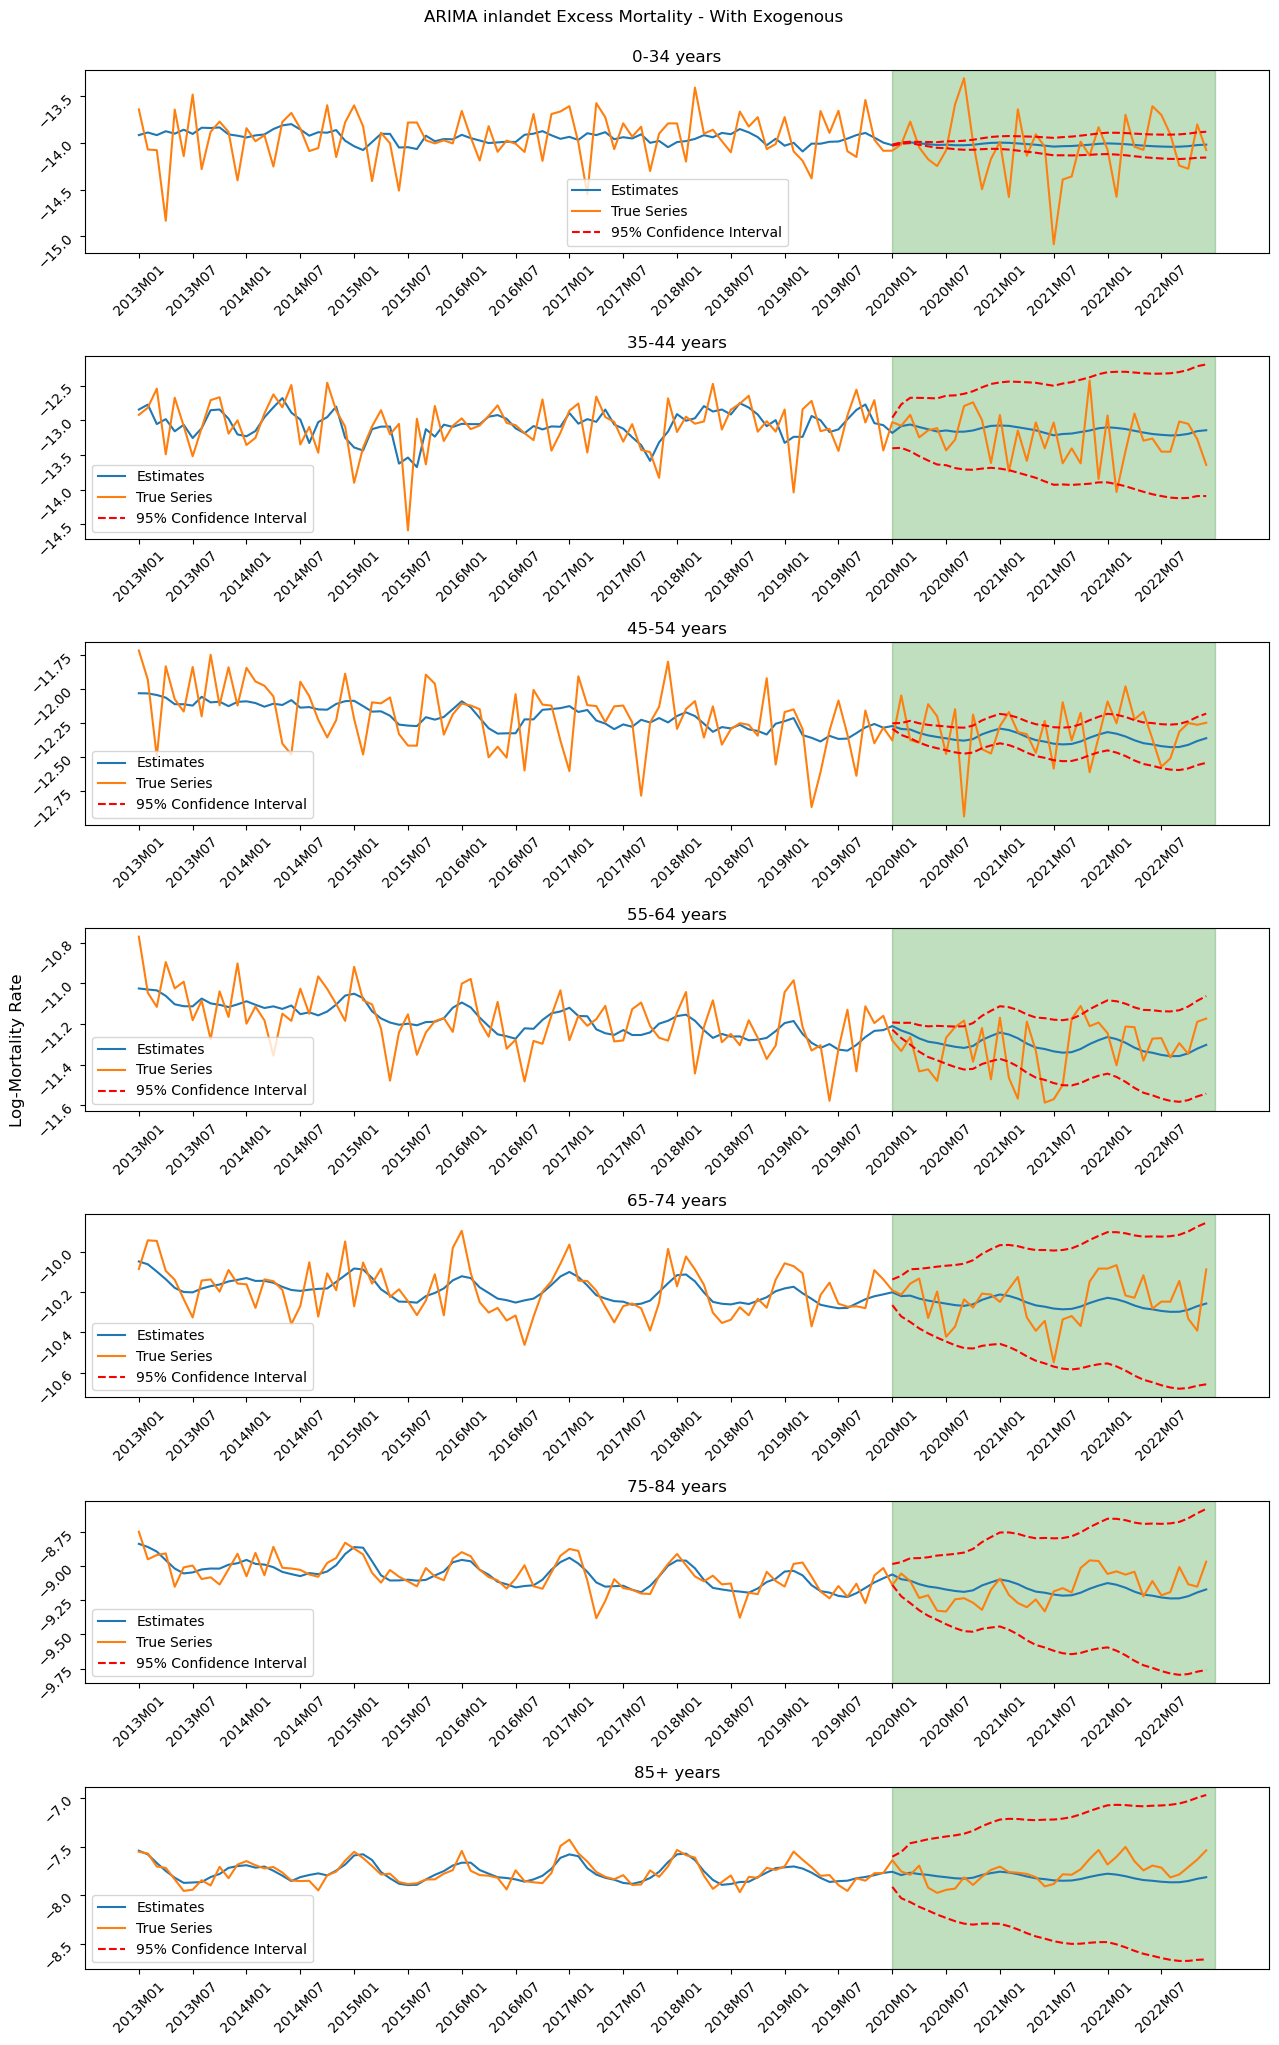

In [51]:
### With Exogenous
a_xi,B_xs,K_ts,b_xs,k_ts,country_re_est,regional_re_est,K_t_models,k_t_models_sarw,K_t_preds,k_t_preds,regional_predictions_sarwithCOVID,regional_predictions_upconf,regional_predictions_lowconf,model_error,res,_,_ = full_model(all_nor_logmort_incCOVID,inlandet_logmort_incCOVID, common_terms = 3,regional_terms = 1,prediction_period = 36,train_period = 84,exogenous_train = exog_train_inlandet_COVID,exogenous_test = exog_test_inlandet_COVID,country_deaths = nor_death_COVID, country_pop = nor_pop_COVID,region_deaths = inlandet_death_COVID,region_pop = inlandet_pop_COVID,re_est = False,smooth = True)  


regional_predictions_sarwithCOVID = pd.DataFrame(regional_predictions_sarwithCOVID)
regional_predictions_upconf = pd.DataFrame(regional_predictions_upconf)
regional_predictions_lowconf = pd.DataFrame(regional_predictions_lowconf)

regional_predictions_sarwithCOVID.index = inlandet_logmort_incCOVID.index
regional_predictions_sarwithCOVID.columns = inlandet_logmort_incCOVID.columns
regional_predictions_upconf.index = inlandet_logmort_incCOVID.index
regional_predictions_upconf.columns = inlandet_logmort_incCOVID.columns
regional_predictions_lowconf.index = inlandet_logmort_incCOVID.index
regional_predictions_lowconf.columns = inlandet_logmort_incCOVID.columns

print("Model Error " + str(model_error))
print("Re_estimation error Each Age Group (MAPE): "+str(MAPE(regional_predictions_sarwithCOVID.iloc[:,:84],inlandet_logmort_incCOVID.iloc[:,:84])))

#AIC_values = [K_t_models["model_0"].aic(),K_t_models["model_1"].aic(),k_t_models["model_0"].aic(),k_t_models["model_1"].aic()]
#print("\n Model AIC Values [K_t1,K_t2,k_t1,k_t2]: \n"+ str(AIC_values))

print("\n Prediction Error Each Age Group (MAPE)" +str(MAPE(regional_predictions_sarwithCOVID.iloc[:,84:],inlandet_logmort_incCOVID.iloc[:,84:])))

#inlandet_pop_inCOVID = undo_person_days(pd.DataFrame(inlandet_pop_inCOVID,columns = inlandet_logmort_incCOVID.columns[-36:]))

exp_term = np.multiply(np.exp(a_xi+B_xs@K_t_preds[:,84:] + b_xs@k_t_preds[:,84:]),inlandet_pop_inCOVID)
exp_term = np.round(exp_term,0)
pred_total_deaths = np.sum(exp_term,axis = 1)
actual_total_deaths = np.sum(inlandet_death_inCOVID,axis = 1)
print("\nPredicted number of deaths for COVID period " + str(pred_total_deaths))
print("Actual number of deaths for COVID period " + str(actual_total_deaths))
print("Actual deaths over predicted deaths " +str(actual_total_deaths/pred_total_deaths))
print("Total Excess Mortality (Actual - Predicted): " + str(np.sum(pred_total_deaths) - np.sum(actual_total_deaths)))
print("Excess Mortality Ratio (Actual/Predicted): " + str(np.sum(pred_total_deaths)/np.sum(actual_total_deaths)))


error_SARIMAX_withCOVID = MAPE(regional_predictions_sarwithCOVID.iloc[:,84:],inlandet_logmort_incCOVID.iloc[:,84:])
prediction_plots(regional_predictions_sarwithCOVID,regional_predictions_upconf,regional_predictions_lowconf,36,inlandet_logmort_incCOVID,suptitle = "ARIMA inlandet Excess Mortality - With Exogenous")



In [44]:
print(str(K_t_models["model_0"].get_params()["order"]) + str(K_t_models["model_0"].get_params()["seasonal_order"]))
print("-")
print(str(k_t_models_sarw["model_0"].get_params()["order"]) + str(k_t_models_sarw["model_0"].get_params()["seasonal_order"]))
print(str(k_t_models_sarw["model_1"].get_params()["order"]) + str(k_t_models_sarw["model_1"].get_params()["seasonal_order"]))
print(str(k_t_models_sarw["model_2"].get_params()["order"]) + str(k_t_models_sarw["model_2"].get_params()["seasonal_order"]))



(1, 0, 0)(1, 0, 1, 12)
-
(0, 1, 1)(0, 0, 1, 12)
(0, 1, 1)(0, 0, 0, 12)
(0, 1, 1)(1, 0, 0, 12)


test_errors[1.91773727 2.06125645 4.82224841 1.090493   1.58761046 1.42847189
 2.26487979]

Predicted number of deaths for COVID period [nan nan nan nan nan nan nan]
Actual number of deaths for COVID period [  417   272   751  1885  4859  8640 13169]
Actual deaths over predicted deaths [nan nan nan nan nan nan nan]
Total Excess Mortality (Actual - Predicted): nan
Excess Mortality Ratio (Actual/Predicted): nan


<Figure size 640x480 with 0 Axes>

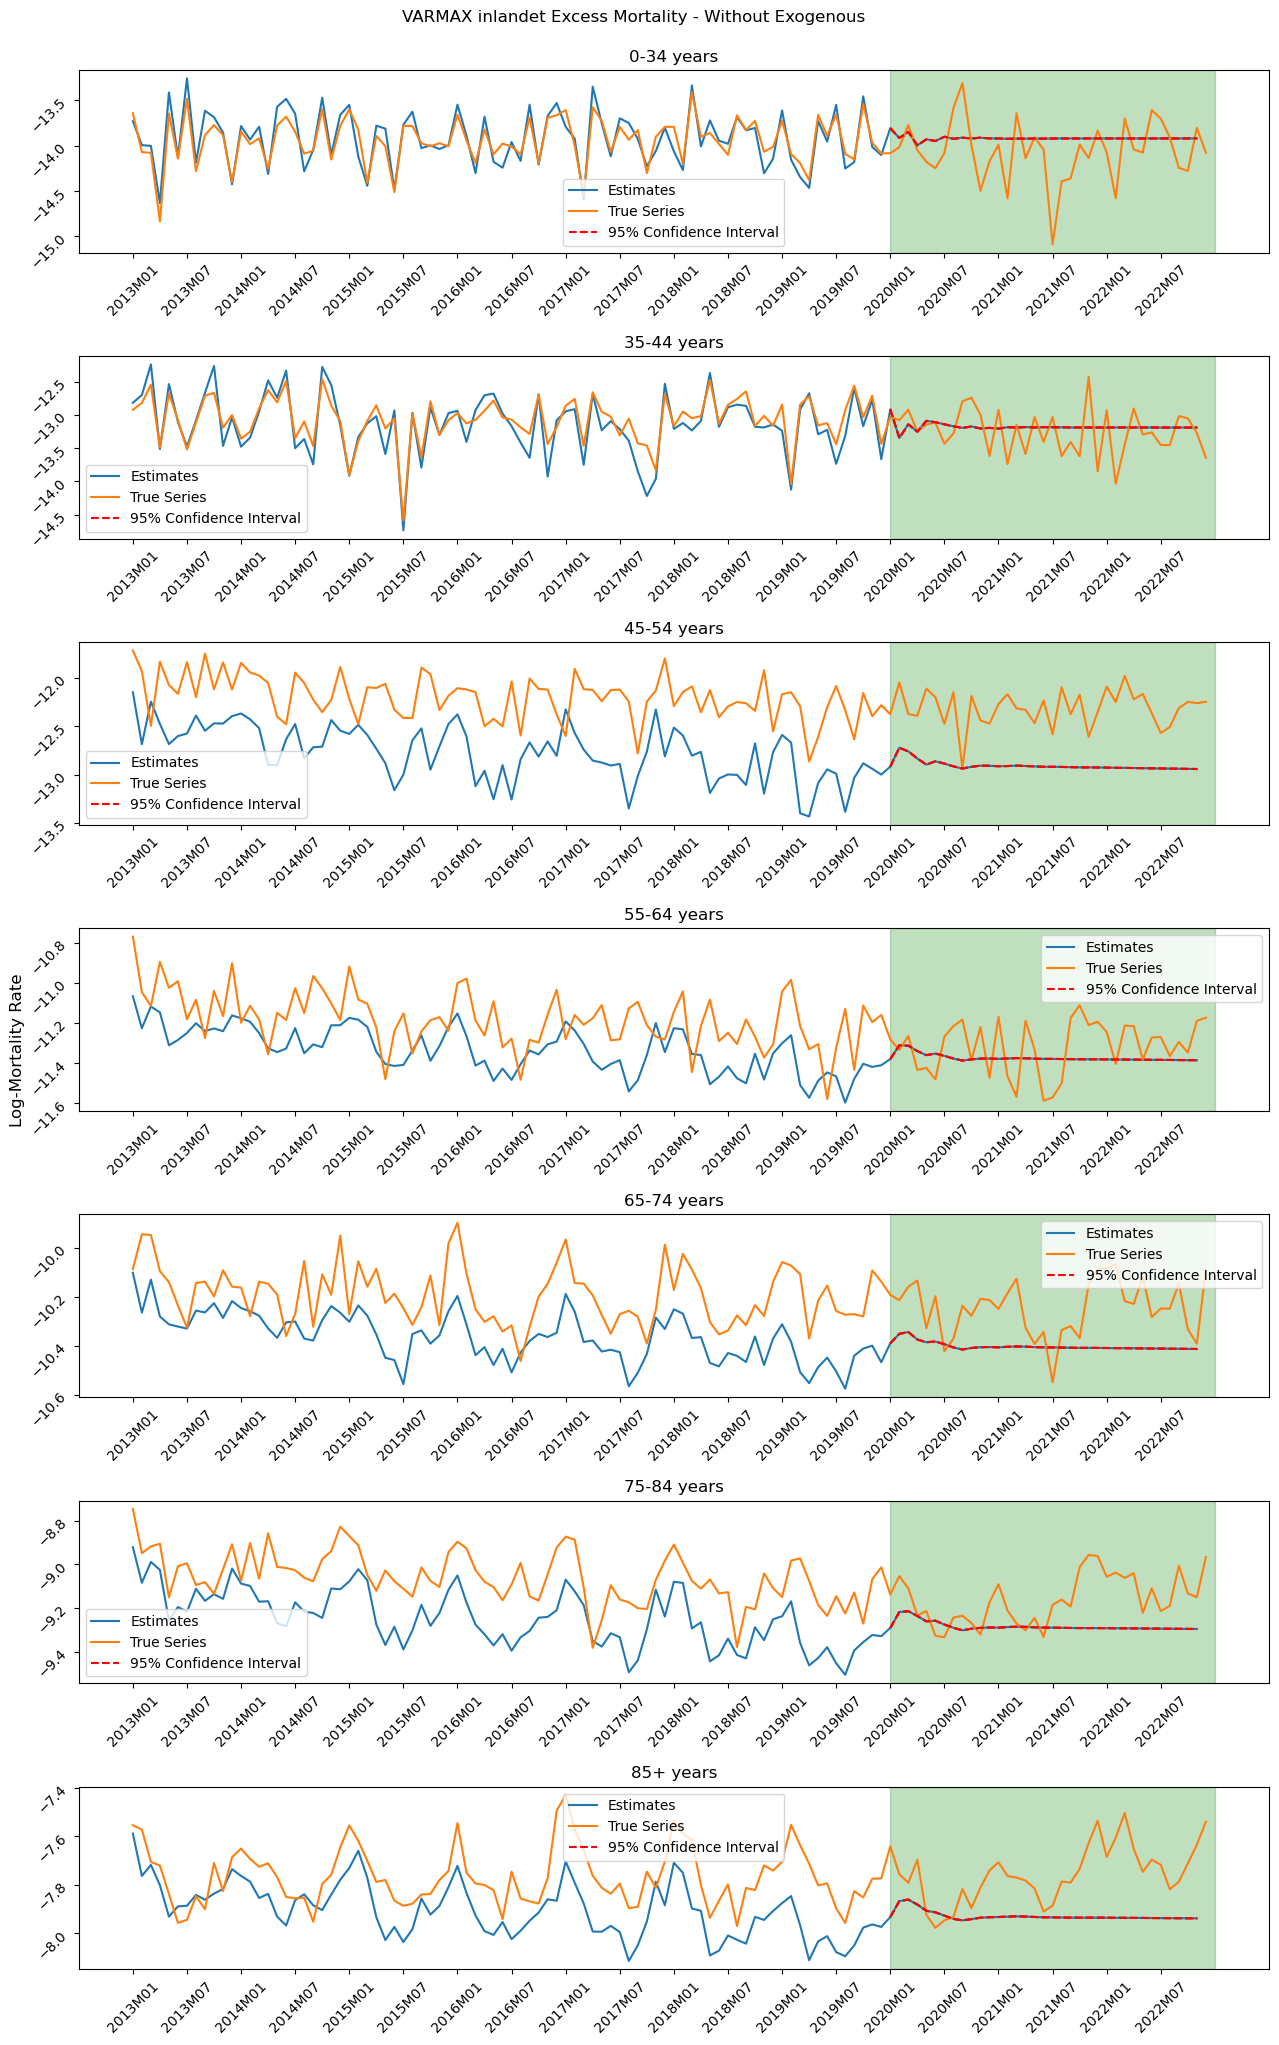

In [52]:
all_k_t, K_ts,k_ts,B_xs,b_xs,a_xi,all_k_preds,predictions_VAR_woutCOVID,predictions_lowconf,predictions_upconf,model_VAR_woutCOVID,aic,error_VAR_woutCOVID,_,_ = VARMAX_model(all_nor_logmort_incCOVID,inlandet_logmort_incCOVID, common_terms = 3,regional_terms = 3,prediction_period = 36,train_period = 84,AR= 3,MA = 2, country_deaths = nor_death_COVID,country_pop = nor_pop_COVID,region_deaths = inlandet_death_COVID,region_pop = inlandet_pop_COVID,re_est = False)


print("test_errors" + str(error_VAR_woutCOVID))

K_t_preds = np.array(all_k_preds.iloc[84:,:3].fillna(method="ffill")).transpose() # change column number to match number of common terms
k_t_preds = np.array(all_k_preds.iloc[84:,3:]).transpose()

#inlandet_pop_inCOVID = undo_person_days(pd.DataFrame(inlandet_pop_inCOVID,columns = inlandet_logmort_incCOVID.columns[-36:]))

exp_term = np.multiply(np.exp(a_xi+B_xs@K_t_preds + b_xs@k_t_preds),inlandet_pop_inCOVID)
exp_term = np.round(exp_term,0)
pred_total_deaths = np.sum(exp_term,axis = 1)
actual_total_deaths = np.sum(inlandet_death_inCOVID,axis = 1)
print("\nPredicted number of deaths for COVID period " + str(pred_total_deaths))
print("Actual number of deaths for COVID period " + str(actual_total_deaths))
print("Actual deaths over predicted deaths " +str(actual_total_deaths/pred_total_deaths))
print("Total Excess Mortality (Actual - Predicted): " + str(np.sum(pred_total_deaths) - np.sum(actual_total_deaths)))
print("Excess Mortality Ratio (Actual/Predicted): " + str(np.sum(pred_total_deaths)/np.sum(actual_total_deaths)))


prediction_plots(predictions_VAR_woutCOVID,predictions_VAR_woutCOVID,predictions_VAR_woutCOVID,36,inlandet_logmort_incCOVID,suptitle = "VARMAX inlandet Excess Mortality - Without Exogenous")



test_errors[1.13437623 1.16906126 3.71176412 2.47077991 3.07181113 4.28941404
 5.23307628]

Predicted number of deaths for COVID period [  429.   267.   601.  1680.  4088.  6970. 10084.]
Actual number of deaths for COVID period [  417   272   751  1885  4859  8640 13169]
Actual deaths over predicted deaths [0.97202797 1.01872659 1.24958403 1.12202381 1.18860078 1.23959828
 1.30593019]


<Figure size 640x480 with 0 Axes>

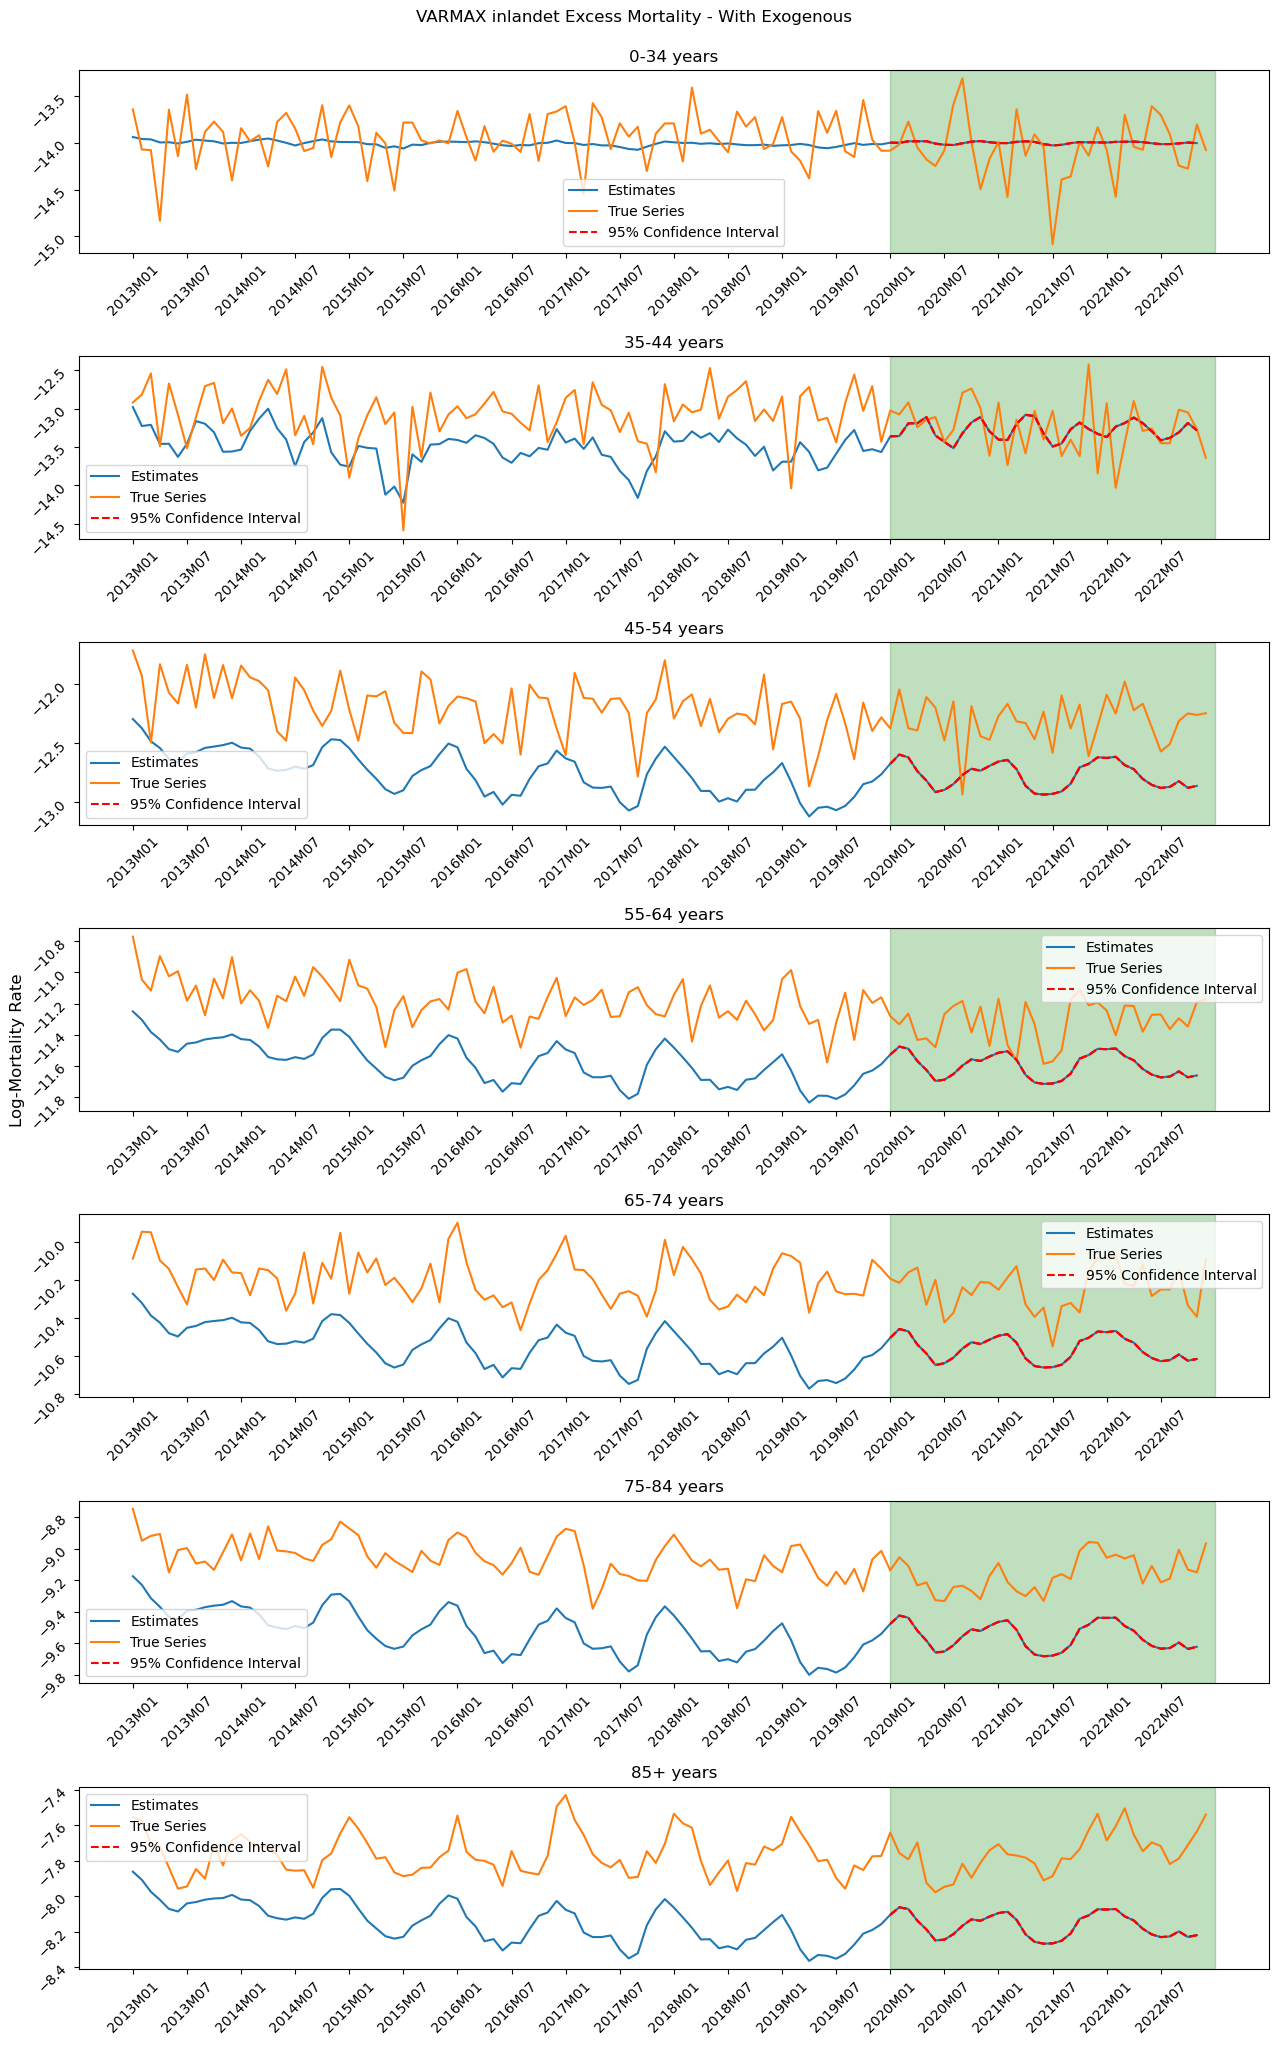

In [53]:
#exog_train_inlandet_COVID = lag_exogenous(exog_train_inlandet_COVID,numlags = 4)
#exog_test_inlandet_COVID = lag_exogenous(exog_test_inlandet_COVID,numlags = 4)
all_k_t, K_ts,k_ts,B_xs,b_xs,a_xi,all_k_preds,predictions_VAR_withCOVID,predictions_lowconf,predictions_upconf,model_VAR_withCOVID,aic,error_VAR_withCOVID,_,_ = VARMAX_model(all_nor_logmort_incCOVID,inlandet_logmort_incCOVID, common_terms = 1,regional_terms = 2,prediction_period = 36,train_period = 84,AR= 4,MA = 4,exogenous_train = exog_train_inlandet_COVID,exogenous_test = exog_test_inlandet_COVID,country_deaths = nor_death_COVID, country_pop = nor_pop_COVID,region_deaths = inlandet_death_COVID,region_pop = inlandet_pop_COVID,re_est = False,smooth = True)


print("test_errors" + str(error_VAR_withCOVID))

K_t_preds = np.array(all_k_preds.iloc[84:,:1].fillna(method="ffill")).transpose()
k_t_preds = np.array(all_k_preds.iloc[84:,1:].fillna(method = "ffill")).transpose()

#inlandet_pop_inCOVID = undo_person_days(pd.DataFrame(inlandet_pop_inCOVID,columns = inlandet_logmort_incCOVID.columns[-36:]))

exp_term = np.multiply(np.exp(a_xi+B_xs@K_t_preds + b_xs@k_t_preds),inlandet_pop_inCOVID)
exp_term = np.round(exp_term,0)
pred_total_deaths = np.sum(exp_term,axis = 1)
actual_total_deaths = np.sum(inlandet_death_inCOVID,axis = 1)
print("\nPredicted number of deaths for COVID period " + str(pred_total_deaths))
print("Actual number of deaths for COVID period " + str(actual_total_deaths))
print("Actual deaths over predicted deaths " +str(actual_total_deaths/pred_total_deaths))

prediction_plots(predictions_VAR_withCOVID,predictions_VAR_withCOVID,predictions_VAR_withCOVID,36,inlandet_logmort_incCOVID,suptitle = "VARMAX inlandet Excess Mortality - With Exogenous")


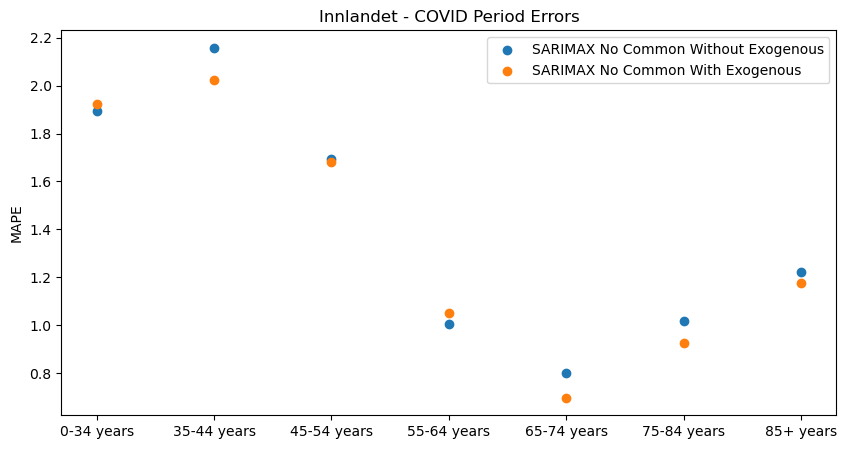

In [56]:
test_errors = np.vstack((error_SARIMAX_woutCOVID,error_SARIMAX_withCOVID,error_VAR_woutCOVID,error_VAR_withCOVID,error_NoCom_woutCOVID,error_NoCom_withCOVID))
inlandet = test_errors

age_groups = inlandet_logmort.index
plt.figure(figsize = (10,5))
# plt.scatter(age_groups,inlandet[0,:],label = "SARIMAX Without Exogenous")
# plt.scatter(age_groups,inlandet[1,:],label = "SARIMAX With Exogenous")
# plt.scatter(age_groups,inlandet[2,:],label = "VARMAX Without Exogenous")
# plt.scatter(age_groups,inlandet[3,:],label = "VARMAX With Exogenous")
plt.scatter(age_groups,inlandet[4,:],label = "SARIMAX No Common Without Exogenous")
plt.scatter(age_groups,inlandet[5,:],label = "SARIMAX No Common With Exogenous")
plt.legend();
plt.ylabel("MAPE")
plt.title("Innlandet - COVID Period Errors");

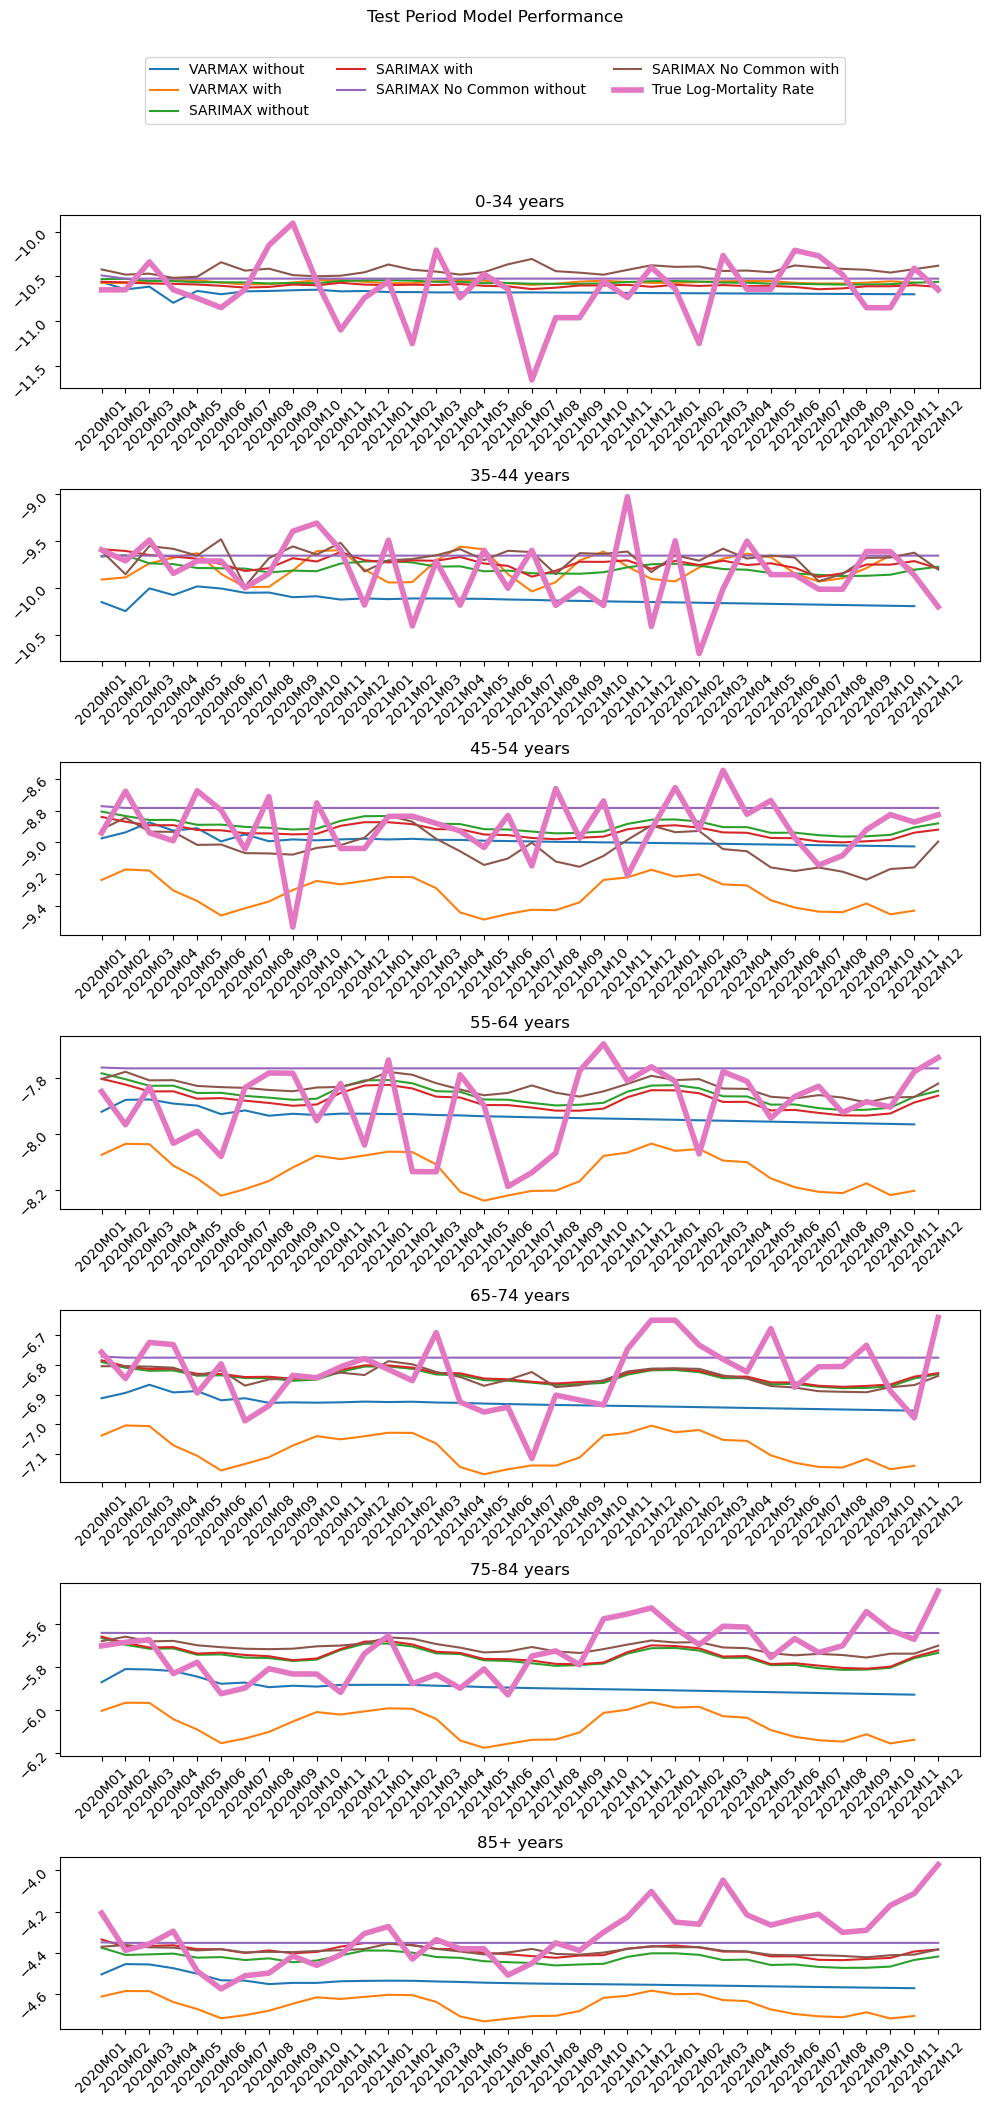

In [23]:
predictions_VAR_withCOVID = pd.DataFrame(predictions_VAR_withCOVID)
predictions_VAR_withCOVID.index = inlandet_logmort_incCOVID.index
predictions_VAR_withCOVID.columns = inlandet_logmort_incCOVID.columns

predictions_VAR_woutCOVID = pd.DataFrame(predictions_VAR_woutCOVID)
predictions_VAR_woutCOVID.index = inlandet_logmort_incCOVID.index
predictions_VAR_woutCOVID.columns = inlandet_logmort_incCOVID.columns


age_groups = inlandet_logmort.index
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(10, 20))

# Store lines and labels to create a single legend
lines = []
labels = []

for row in range(7):
    age = age_groups[row]
    axes[row].set_title(age)
    
    line1, = axes[row].plot(predictions_VAR_woutCOVID.iloc[row, 84:], label="VARMAX without")
    line2, = axes[row].plot(predictions_VAR_withCOVID.iloc[row, 84:], label="VARMAX with")
    line3, = axes[row].plot(regional_predictions_saroutCOVID.iloc[row, 84:], label="SARIMAX without")
    line4, = axes[row].plot(regional_predictions_sarwithCOVID.iloc[row, 84:], label="SARIMAX with")
    line5, = axes[row].plot(regional_predictions_nocommoutCOVID.iloc[row, 84:], label="SARIMAX No Common without")
    line6, = axes[row].plot(regional_predictions_nocommwithCOVID.iloc[row, 84:], label="SARIMAX No Common with")
    line7, = axes[row].plot(inlandet_logmort_incCOVID.iloc[row, 84:], label="True Log-Mortality Rate", linewidth=4)
    
    axes[row].tick_params(rotation=45)
    
    # Collect lines and labels for the legend
    if row == 0:
        lines.extend([line1, line2, line3, line4, line5, line6, line7])
        labels.extend([line.get_label() for line in lines])

# Create a single legend
fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=3)
plt.suptitle("Test Period Model Performance", y=1.05)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

Note: year 7 is only half an epiyear!  + First 6 months disregarded
Note: year 8 is only half an epiyear!  + First 6 months disregarded


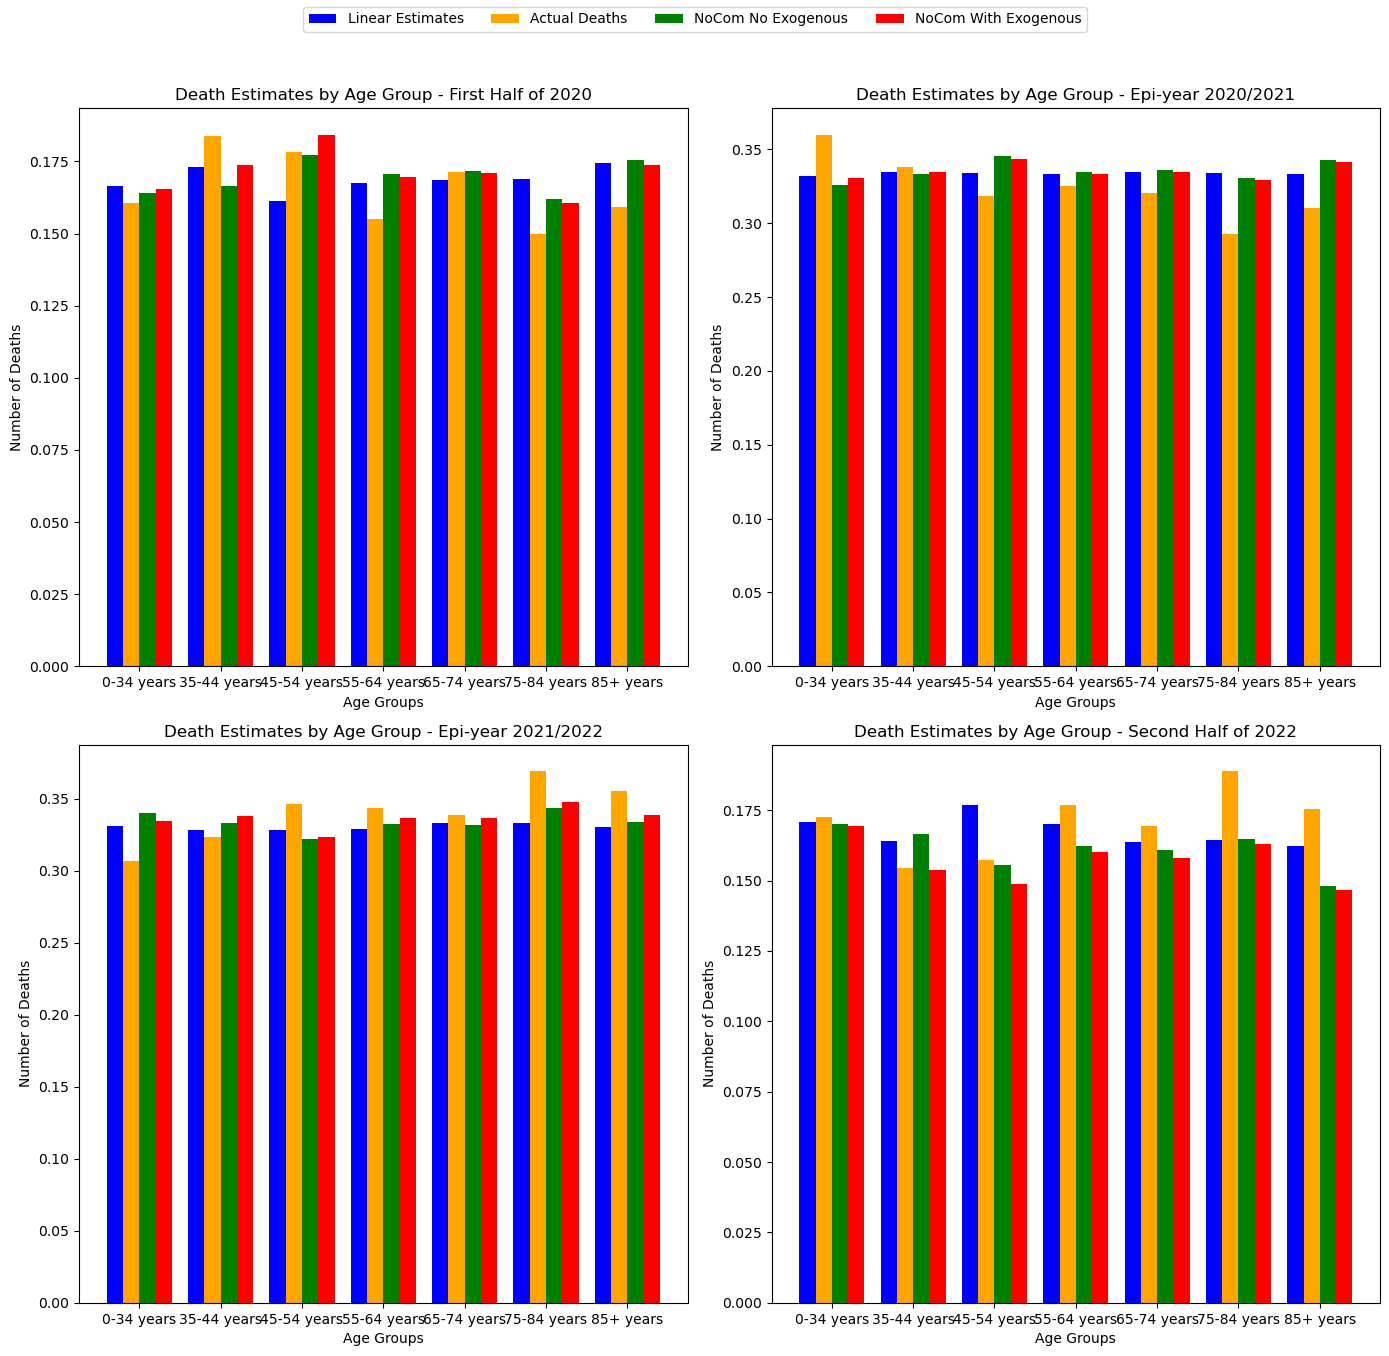

In [33]:
### Compile predictions for excess mortality for epidemic years
lin_ests_20 = np.round(est_half2_epiyear(inlandet_death_COVID),0) #estimate for first 6 moths of 2020 ie. second half epi-year 19/20

#Use 2019/20 epi-year in estimate for epi-year 2020/21?  
lin_ests_20_21 = np.reshape(epi_year_lin_ests(pd.DataFrame(inlandet_death_full.iloc[:,:96])),(7,))
lin_ests_21_22 = np.reshape(epi_year_lin_ests(pd.DataFrame(inlandet_death_full.iloc[:,:108])),(7,))

#estimate for last 6 months of 2022 ie. first half epi-year 19/20
lin_ests_22 = np.round(est_half1_epiyear(inlandet_death_COVID),0) #estimate for first 6 moths of 2020 ie. second half epi-year 19/20

# only first half of 2020, second half of epi-year 19/20
inlandet_actual_deaths_20 = inlandet_death_full.iloc[:,84:90].sum(axis = 1) 
inlandet_actual_deaths_20_21 = epi_year(inlandet_death_full.iloc[:,84:])["year_0"].sum(axis = 1)
inlandet_actual_deaths_21_22 = epi_year(inlandet_death_full.iloc[:,84:])["year_1"].sum(axis = 1)
inlandet_actual_deaths_22 = epi_year(inlandet_death_full.iloc[:,84:])["year_2"].sum(axis = 1) #only second half of 2022 


age_groups = inlandet_logmort_full.index
r = np.arange(len(age_groups))
width = 0.2  # Adjusting width to fit four bars

fig, axes = plt.subplots(2, 2, figsize=(14, 14))  # Creating a 2x2 grid of subplots

# Labels for the legends
labels = ["Linear Estimates", "Actual Deaths", "NoCom No Exogenous", "NoCom With Exogenous"]

# Defining data sets for each subplot
data_sets = [
    (lin_ests_20, inlandet_actual_deaths_20, inlandet_NoCom_NoExog_deaths_20, inlandet_NoCom_WithExog_deaths_20),
    (lin_ests_20_21, inlandet_actual_deaths_20_21, inlandet_NoCom_NoExog_deaths_20_21, inlandet_NoCom_WithExog_deaths_20_21),
    (lin_ests_21_22, inlandet_actual_deaths_21_22, inlandet_NoCom_NoExog_deaths_21_22, inlandet_NoCom_WithExog_deaths_21_22),
    (lin_ests_22, inlandet_actual_deaths_22, inlandet_NoCom_NoExog_deaths_22, inlandet_NoCom_WithExog_deaths_22)
]
data_sets = data_sets/np.sum(data_sets,axis = 0)

titles = [
    'Death Estimates by Age Group - First Half of 2020',
    'Death Estimates by Age Group - Epi-year 2020/2021',
    'Death Estimates by Age Group - Epi-year 2021/2022',
    'Death Estimates by Age Group - Second Half of 2022'
]

for ax, data, title in zip(axes.flatten(), data_sets, titles):
    lin_est, actual_death, NoCom_noexog, NoCom_withexog = data
    ax.bar(r - 1.5*width, lin_est, width=width, align="center", color="blue", label=labels[0])
    ax.bar(r - 0.5*width, actual_death, width=width, align="center", color="orange", label=labels[1])
    ax.bar(r + 0.5*width, NoCom_noexog, width=width, align="center", color="green", label=labels[2])
    ax.bar(r + 1.5*width, NoCom_withexog, width=width, align="center", color="red", label=labels[3])
    ax.set_xticks(r)
    ax.set_xticklabels(age_groups)
    ax.set_xlabel('Age Groups')
    ax.set_ylabel('Number of Deaths')
    ax.set_title(title)

# Adding a single legend for the whole figure
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the legend
plt.show()






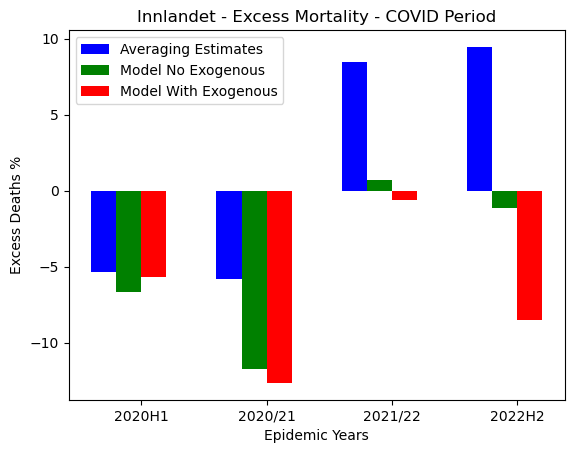

In [59]:


inlandet_actual_deaths_total_20 = np.sum(inlandet_actual_deaths_20)
lin_ests_excess_20 = (inlandet_actual_deaths_total_20 - np.sum(lin_ests_20))/inlandet_actual_deaths_total_20 *100
inlandet_NoCom_NoExog_excess_total_20 = (inlandet_actual_deaths_total_20 - np.sum(inlandet_NoCom_NoExog_deaths_20))/inlandet_actual_deaths_total_20 *100
inlandet_NoCom_WithExog_excess_total_20 = (inlandet_actual_deaths_total_20 - np.sum(inlandet_NoCom_WithExog_deaths_20))/inlandet_actual_deaths_total_20 *100

inlandet_actual_deaths_total_20_21 = np.sum(inlandet_actual_deaths_20_21)
lin_ests_excess_20_21 = (inlandet_actual_deaths_total_20_21 - np.sum(lin_ests_20_21))/inlandet_actual_deaths_total_20_21 *100
inlandet_NoCom_NoExog_excess_total_20_21 = (inlandet_actual_deaths_total_20_21 - np.sum(inlandet_NoCom_NoExog_deaths_20_21))/inlandet_actual_deaths_total_20_21 *100
inlandet_NoCom_WithExog_excess_total_20_21 = (inlandet_actual_deaths_total_20_21 - np.sum(inlandet_NoCom_WithExog_deaths_20_21))/inlandet_actual_deaths_total_20_21 *100

inlandet_actual_deaths_total_21_22 = np.sum(inlandet_actual_deaths_21_22)
lin_ests_excess_21_22 = (inlandet_actual_deaths_total_21_22 - np.sum(lin_ests_21_22))/inlandet_actual_deaths_total_21_22 *100
inlandet_NoCom_NoExog_excess_total_21_22 = (inlandet_actual_deaths_total_21_22 - np.sum(inlandet_NoCom_NoExog_deaths_21_22))/inlandet_actual_deaths_total_21_22 *100
inlandet_NoCom_WithExog_excess_total_21_22 = (inlandet_actual_deaths_total_21_22 - np.sum(inlandet_NoCom_WithExog_deaths_21_22))/inlandet_actual_deaths_total_21_22 *100

inlandet_actual_deaths_total_22 = np.sum(inlandet_actual_deaths_22)
lin_ests_excess_22 = (inlandet_actual_deaths_total_22 - np.sum(lin_ests_22))/inlandet_actual_deaths_total_22 *100
inlandet_NoCom_NoExog_excess_total_22 = (inlandet_actual_deaths_total_22 - np.sum(inlandet_NoCom_NoExog_deaths_22))/inlandet_actual_deaths_total_22 *100
inlandet_NoCom_WithExog_excess_total_22 = (inlandet_actual_deaths_total_22 - np.sum(inlandet_NoCom_WithExog_deaths_22))/inlandet_actual_deaths_total_22 *100


# Assuming inlandet_logmort_full, lin_ests_20, inlandet_actual_deaths_20, inlandet_NoCom_NoExog_deaths_20, and inlandet_NoCom_WithExog_deaths_20 are defined
# inlandet_logmort_full.index should be a list or an array of age groups

years = ["2020H1", "2020/21","2021/22", "2022H2"]
r = np.arange(len(years))
width = 0.2  # Adjusting width to fit four bars

# Labels for the legends
labels = ["Averaging Estimates", "Model No Exogenous", "Model With Exogenous","_nolegend_"]

plt.bar(r[0] - 1.5*width, lin_ests_excess_20, width=0.2, align="center", color="blue", label=labels[0])
plt.bar(r[0] - 0.5*width, inlandet_NoCom_NoExog_excess_total_20, width=0.2, align="center", color="green", label=labels[1])
plt.bar(r[0] + 0.5*width, inlandet_NoCom_WithExog_excess_total_20, width=0.2, align="center", color="red", label=labels[2])
#plt.bar(r[0] + 1.5*width, inlandet_actual_deaths_total_20, width=0.2, align="center", color="orange", label=labels[0])

plt.bar(r[1] - 1.5*width, lin_ests_excess_20_21, width=0.2, align="center", color="blue", label=labels[3])
plt.bar(r[1] - 0.5*width, inlandet_NoCom_NoExog_excess_total_20_21, width=0.2, align="center", color="green", label=labels[3])
plt.bar(r[1] + 0.5*width, inlandet_NoCom_WithExog_excess_total_20_21, width=0.2, align="center", color="red", label=labels[3])
#plt.bar(r[1] + 1.5*width, inlandet_actual_deaths_total_20_21, width=0.2, align="center", color="orange", label=labels[0])

plt.bar(r[2] - 1.5*width, lin_ests_excess_21_22, width=0.2, align="center", color="blue", label=labels[3])
plt.bar(r[2] - 0.5*width, inlandet_NoCom_NoExog_excess_total_21_22, width=0.2, align="center", color="green", label=labels[3])
plt.bar(r[2] + 0.5*width, inlandet_NoCom_WithExog_excess_total_21_22, width=0.2, align="center", color="red", label=labels[3])

plt.bar(r[3] - 1.5*width, lin_ests_excess_22, width=0.2, align="center", color="blue", label=labels[3])
plt.bar(r[3] - 0.5*width, inlandet_NoCom_NoExog_excess_total_22, width=0.2, align="center", color="green", label=labels[3])
plt.bar(r[3] + 0.5*width, inlandet_NoCom_WithExog_excess_total_22, width=0.2, align="center", color="red", label=labels[3])

plt.xticks(r, years)
plt.legend()
plt.xlabel('Epidemic Years')
plt.ylabel('Excess Deaths %')
plt.title('Innlandet - Excess Mortality - COVID Period');
# plt.show()

